# Google Drive Interface Setup

In [1]:
from google.colab import drive, auth
import sys

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Pull down github repo, store in colab runtime memory
!git clone https://github.com/andrew-loeber/proj_utils_207.git

Cloning into 'proj_utils_207'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 34 (delta 10), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (34/34), 8.72 KiB | 1.74 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [4]:
# Tell Python to also look in this repo when running an import
sys.path.insert(1, "/content/proj_utils_207")

In [5]:
# Authenticate google account and give back the session access token
auth.authenticate_user()
gcloud_token = !gcloud auth print-access-token
gcloud_token

['ya29.a0AbVbY6PiUKhG3M_Ur3YbH0dXOvbLTcPLnfcmIuL91g_HJgYWl9P6J1GF1W90IIgYQ5yifkZyczEf-mKeFV33vrKmWfKEGHbBdF89L_lJ2Gt-1ZJ16unWyXRo84cioPVoz1xicaKlJcJIR615CpRSTFTY_NpmaCgYKASISARASFQFWKvPl1bFZSIrCQeBWm2H88Pt1dw0163']

In [6]:
from gdriveinterface import GDriveInterface
import proj_ref

In [7]:
# Show email address, username, and the path of the shared project folder on
# your Google Drive instance
gdi = GDriveInterface(gcloud_token)
shared_folder_path = gdi.shared_folder_path
gdi.__dict__

{'email': 'aloeber@berkeley.edu',
 'account': 'aloeber',
 'shared_folder_path': '/content/drive/MyDrive/207-Project'}

In [8]:
# Show name keys and paths for tracked files
proj_ref.files

{'taxonomy': 'BirdCLEF/eBird_Taxonomy_v2021.csv',
 'orig_metadata': 'BirdCLEF/train_metadata_with_duration.csv',
 'sample_metadata': 'data/sample_metadata.csv',
 'species_metadata': 'data/species_metadata.csv',
 'train_metadata': 'data/train_metadata.csv',
 'test_metadata': 'data/test_metadata.csv'}

In [9]:
# Show name keys and paths for tracked directories
proj_ref.dirs

{'orig_audio': {'path': 'BirdCLEF/train_audio'},
 'train_audio': {'path': 'data/train/audio_files'},
 'test_audio': {'path': 'data/test/audio_files'},
 'train_npy_full': {'path': 'data/train/librosa_loaded'},
 'test_npy_full': {'path': 'data/test/librosa_loaded'},
 'train_npy_loud5s': {'path': 'data/train/librosa_loaded_loudest_5sec'},
 'test_npy_loud5s': {'path': 'data/test/librosa_loaded_loudest_5sec'}}

### **Usage examples**

##### Query specific file based on named key
```
command: gdi.get_file_path('taxonomy')
returns: '/content/drive/MyDrive/207-Project/BirdCLEF/eBird_Taxonomy_v2021.csv'
```

##### Query specific directory based on named key
```
command: gdi.get_dir_path('orig_audio')
returns: '/content/drive/MyDrive/207-Project/BirdCLEF/train_audio'
```

##### Query specific sample record based on named keys for directory and file
```
command: gdi.get_sample_path('train_audio', 'barswa/XC132406.ogg')
returns: '/content/drive/MyDrive/207-Project/data/train/audio_files/barswa/XC132406.ogg'
```

##### Provide full path given a custom partial path
```
command: gdi.join_to_shared('images/sandpiper.jpeg')
returns: '/content/drive/MyDrive/207-Project/images/sandpiper.jpeg'
```


# Imports and Setup

In [10]:
!pip install audiomentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 1.6 MB/s eta 0:00:00


In [11]:
!pip install colorednoise

In [12]:
# !pip install keras-nlp --upgrade

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
# import tensorflow_addons as tfa
import librosa
from IPython.display import Audio
import audiomentations as am
import colorednoise as cn
from sklearn.decomposition import NMF

In [14]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Read in sample metadata

In [269]:
sample_meta_df = pd.read_csv(gdi.get_file_path('sample_metadata'))
sample_meta_df

primary_label          common_name    scientific_name  species_rank  \
0          thrnig1   Thrush Nightingale  Luscinia luscinia             0   
1          thrnig1   Thrush Nightingale  Luscinia luscinia             0   
2          thrnig1   Thrush Nightingale  Luscinia luscinia             0   
3          thrnig1   Thrush Nightingale  Luscinia luscinia             0   
4          thrnig1   Thrush Nightingale  Luscinia luscinia             0   
...            ...                  ...                ...           ...   
4675       cohmar1  Common House-Martin   Delichon urbicum             9   
4676       cohmar1  Common House-Martin   Delichon urbicum             9   
4677       cohmar1  Common House-Martin   Delichon urbicum             9   
4678       cohmar1  Common House-Martin   Delichon urbicum             9   
4679       cohmar1  Common House-Martin   Delichon urbicum             9   

                  filename dataset  duration_secs  duration_mins  \
0     thrnig1/XC110335.ogg   train     119.275102       1.987918   
1     thrnig1/XC110336.ogg   train     122.044127       2.034069   
2     thrnig1/XC112492.ogg    test      58.540408       0.975673   
3     thrnig1/XC118260.ogg   train      44.382041       0.739701   
4     thrnig1/XC120947.ogg   train     189.231066       3.153851   
...                    ...     ...            ...            ...   
4675  cohmar1/XC749483.ogg   train      20.950249       0.349171   
4676  cohmar1/XC749488.ogg    test      71.915102       1.198585   
4677  cohmar1/XC749637.ogg    test       5.040000       0.084000   
4678  cohmar1/XC749638.ogg   train       6.984036       0.116401   
4679  cohmar1/XC751198.ogg   train      17.266032       0.287767   

      duration_hrs  species_total_files  species_train_files  \
0         0.033132                  499                  349   
1         0.033901                  499                  349   
2         0.016261                  499                  349   
3         0.012328                  499                  349   
4         0.052564                  499                  349   
...            ...                  ...                  ...   
4675      0.005820                  408                  286   
4676      0.019976                  408                  286   
4677      0.001400                  408                  286   
4678      0.001940                  408                  286   
4679      0.004796                  408                  286   

      species_test_files  species_total_duration_hrs  \
0                    150                   17.078735   
1                    150                   17.078735   
2                    150                   17.078735   
3                    150                   17.078735   
4                    150                   17.078735   
...                  ...                         ...   
4675                 122                    5.656965   
4676                 122                    5.656965   
4677                 122                    5.656965   
4678                 122                    5.656965   
4679                 122                    5.656965   

      species_train_duration_hrs  species_test_duration_hrs  total_files  \
0                      10.739077                   6.339658         4680   
1                      10.739077                   6.339658         4680   
2                      10.739077                   6.339658         4680   
3                      10.739077                   6.339658         4680   
4                      10.739077                   6.339658         4680   
...                          ...                        ...          ...   
4675                    4.103189                   1.553775         4680   
4676                    4.103189                   1.553775         4680   
4677                    4.103189                   1.553775         4680   
4678                    4.103189                   1.553775         4680 

In [270]:
train_meta_df = pd.read_csv(gdi.get_file_path('train_metadata'))
train_meta_df

primary_label          common_name    scientific_name  species_rank  \
0          thrnig1   Thrush Nightingale  Luscinia luscinia             0   
1          thrnig1   Thrush Nightingale  Luscinia luscinia             0   
2          thrnig1   Thrush Nightingale  Luscinia luscinia             0   
3          thrnig1   Thrush Nightingale  Luscinia luscinia             0   
4          thrnig1   Thrush Nightingale  Luscinia luscinia             0   
...            ...                  ...                ...           ...   
3273       cohmar1  Common House-Martin   Delichon urbicum             9   
3274       cohmar1  Common House-Martin   Delichon urbicum             9   
3275       cohmar1  Common House-Martin   Delichon urbicum             9   
3276       cohmar1  Common House-Martin   Delichon urbicum             9   
3277       cohmar1  Common House-Martin   Delichon urbicum             9   

                  filename dataset  duration_secs  duration_mins  \
0     thrnig1/XC110335.ogg   train     119.275102       1.987918   
1     thrnig1/XC110336.ogg   train     122.044127       2.034069   
2     thrnig1/XC118260.ogg   train      44.382041       0.739701   
3     thrnig1/XC120947.ogg   train     189.231066       3.153851   
4     thrnig1/XC125024.ogg   train      45.312018       0.755200   
...                    ...     ...            ...            ...   
3273  cohmar1/XC748724.ogg   train      54.909025       0.915150   
3274  cohmar1/XC748726.ogg   train       6.974694       0.116245   
3275  cohmar1/XC749483.ogg   train      20.950249       0.349171   
3276  cohmar1/XC749638.ogg   train       6.984036       0.116401   
3277  cohmar1/XC751198.ogg   train      17.266032       0.287767   

      duration_hrs  species_total_files  species_train_files  \
0         0.033132                  499                  349   
1         0.033901                  499                  349   
2         0.012328                  499                  349   
3         0.052564                  499                  349   
4         0.012587                  499                  349   
...            ...                  ...                  ...   
3273      0.015253                  408                  286   
3274      0.001937                  408                  286   
3275      0.005820                  408                  286   
3276      0.001940                  408                  286   
3277      0.004796                  408                  286   

      species_test_files  species_total_duration_hrs  \
0                    150                   17.078735   
1                    150                   17.078735   
2                    150                   17.078735   
3                    150                   17.078735   
4                    150                   17.078735   
...                  ...                         ...   
3273                 122                    5.656965   
3274                 122                    5.656965   
3275                 122                    5.656965   
3276                 122                    5.656965   
3277                 122                    5.656965   

      species_train_duration_hrs  species_test_duration_hrs  total_files  \
0                      10.739077                   6.339658         4680   
1                      10.739077                   6.339658         4680   
2                      10.739077                   6.339658         4680   
3                      10.739077                   6.339658         4680   
4                      10.739077                   6.339658         4680   
...                          ...                        ...          ...   
3273                    4.103189                   1.553775         4680   
3274                    4.103189                   1.553775         4680   
3275                    4.103189                   1.553775         4680   
3276                    4.103189                   1.553775         4680 

# Define helper functions

In [17]:
def load_random_clip(
    file_path
    , file_duration
    , clip_secs=5.0
  ):

  offset = np.random.uniform(low=0.0, high=file_duration - clip_secs)
  audio, sr = librosa.load(
    path=file_path
    , sr=None
    , offset=offset
    , duration=clip_secs
    , dtype=np.float32
  )
  return audio, sr, (offset, offset + clip_secs)


def load_resampled_random_clip(
    file_path
    , file_duration
    , clip_secs=5.0
    , target_sr=16000
  ):

  offset = np.random.uniform(low=0.0, high=file_duration - clip_secs)
  audio, sr = librosa.load(
    path=file_path
    , sr=target_sr
    , offset=offset
    , duration=clip_secs
    , dtype=np.float32
  )
  return audio, sr, (offset, offset + clip_secs)



In [311]:
def load_random_npy_clip(
    file_path
    ,sr=16000
    ,clip_frames=80000
  ):
  audio = np.load(file_path)
  frames = len(audio)
  secs = frames / sr
  clip_start_frame = np.random.randint(0, frames - clip_frames)
  clip_frames = (clip_start_frame, clip_start_frame + clip_frames)
  clip_secs = tuple(map(lambda x: x / sr, clip_frames))
  clip_audio = audio[clip_frames[0] : clip_frames[1]]
  return {
      'clip': clip_audio
      , 'sr': sr
      , 'frames': frames
      , 'clip_frames': clip_frames
      , 'secs': secs
      , 'clip_secs': clip_secs
  }


In [316]:
np_path = gdi.get_sample_path('train_npy_full', 'barswa/XC141678.npy')
loaded_npy = load_random_npy_clip(np_path)
loaded_npy

{'clip': array([ 0.00739971, -0.00158406,  0.01332721, ..., -0.05461218,
         0.01669567,  0.0586049 ], dtype=float32),
 'sr': 16000,
 'frames': 2325107,
 'clip_frames': (1703699, 1783699),
 'secs': 145.3191875,
 'clip_secs': (106.4811875, 111.4811875)}

In [265]:
Audio(loaded_npy['clip'], rate=8000, autoplay=True)

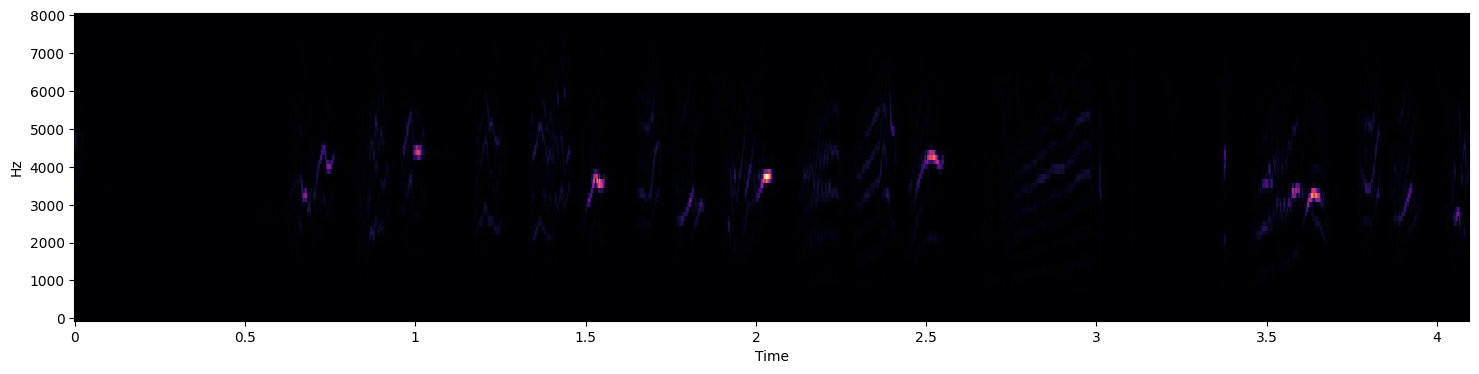

In [266]:
S = np.abs(librosa.stft(loaded_npy['clip'], n_fft=128, hop_length=32))
plt.figure(figsize=(18,4))
librosa.display.specshow(
    S
    , x_axis='time'
    , y_axis='linear'
    , sr=loaded_npy['sr']
    , hop_length=32
)

In [267]:
S.shape

(65, 2048)

In [18]:
def audio_compress(samples, sample_rate, mu_min=1, mu_max=17):
  mu = np.random.uniform(low=mu_min, high=mu_max)
  return librosa.mu_compress(samples, mu=mu, quantize=False)

def audio_expand(samples, sample_rate, mu_min=1, mu_max=17):
  mu = np.random.uniform(low=mu_min, high=mu_max)
  return librosa.mu_expand(samples, mu=mu, quantize=False)

def add_silent_frames(samples, sample_rate, p_min=5e-5, p_max=5e-2):
  p_min_log, p_max_log = np.log(p_min), np.log(p_max)
  prob_log = np.random.uniform(low=p_min_log, high=p_max_log)
  prob = np.exp(prob_log)
  mask = np.random.binomial(n=1, p=1-prob, size=len(samples))
  return mask * samples

def add_crackle(samples, sample_rate, p_min=1e-6, p_max=2e-4):
  p_min_log, p_max_log = np.log(p_min), np.log(p_max)
  prob_log = np.random.uniform(low=p_min_log, high=p_max_log)
  prob = np.exp(prob_log)
  mask = np.random.binomial(n=1, p=prob, size=len(samples))
  noise = np.random.binomial(n=1, p=0.5, size=len(samples)) * 2 - 1
  return np.where(mask, noise, samples)

def add_colored_noise(
    samples
    , sample_rate
    , exp_min=-4
    , exp_max=2
    , scale_min=0.005
    , scale_max=0.025
    ):
  exp = np.random.uniform(low=exp_min, high=exp_max)
  scale = np.random.uniform(low=scale_min, high=scale_max)
  noise = cn.powerlaw_psd_gaussian(exp, size=len(samples))
  return samples + (scale * noise)

def add_colored_noise2(
    samples
    , sample_rate
    , min_gain_db=-18.0
    , max_gain_db=18.0
    , scale_min=0.005
    , scale_max=0.05
    ):
  eq = am.SevenBandParametricEQ(
      min_gain_db=min_gain_db
      , max_gain_db=max_gain_db
      , p=1.0
  )
  norm = am.Normalize(p=1.0)
  scale = np.random.uniform(low=scale_min, high=scale_max)
  noise = np.random.randn(len(samples))
  noise = eq(noise, sample_rate=sample_rate)
  noise = norm(noise, sample_rate=sample_rate)
  return samples + (scale * noise)

# Exploration

In [ ]:
noise = 0.5 * cn.powerlaw_psd_gaussian(-5, 100000) + cn.powerlaw_psd_gaussian(1.25, 100000)
Audio(noise, rate=32000, autoplay=True)

In [ ]:
noise.shape

(100000,)

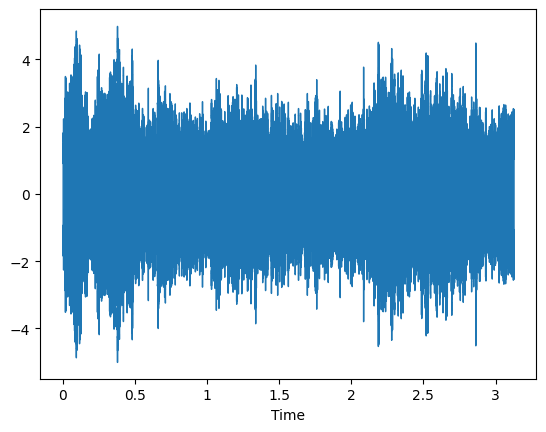

In [ ]:
librosa.display.waveshow(noise, sr=32000)

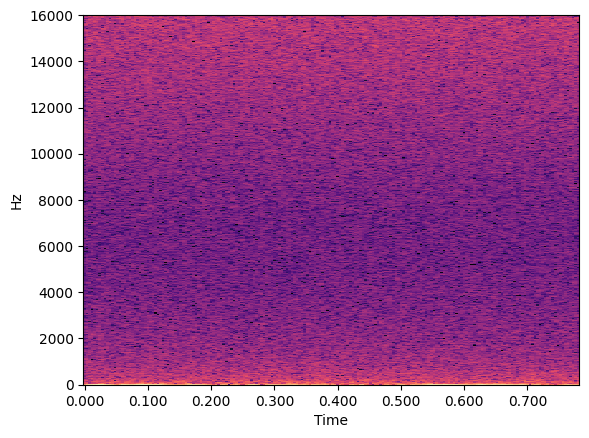

In [ ]:
S = np.abs(librosa.stft(noise, n_fft=2048, hop_length=512))
S_db = librosa.amplitude_to_db(S, ref=np.max)
librosa.display.specshow(
    S_db
    , x_axis='time'
    , y_axis='linear'
    , sr=32000
    , hop_length=128
)

In [ ]:
def load_random_clip(
    file_path
    , file_duration
    , clip_secs=5.0
  ):

  offset = np.random.uniform(low=0.0, high=file_duration - clip_secs)
  audio, sr = librosa.load(
    path=file_path
    , sr=None
    , offset=offset
    , duration=clip_secs
    , dtype=np.float32
  )
  return audio, sr, (offset, offset + clip_secs)


def load_resampled_random_clip(
    file_path
    , file_duration
    , clip_secs=5.0
    , target_sr=16000
  ):

  offset = np.random.uniform(low=0.0, high=file_duration - clip_secs)
  audio, sr = librosa.load(
    path=file_path
    , sr=target_sr
    , offset=offset
    , duration=clip_secs
    , dtype=np.float32
  )
  return audio, sr, (offset, offset + clip_secs)


In [ ]:
file_path = gdi.get_sample_path('train_audio', 'cohmar1/XC749483.ogg')
file_path

'/content/drive/MyDrive/207-Project/data/train/audio_files/cohmar1/XC749483.ogg'

In [ ]:
audio_clip, sr, segment = load_resampled_random_clip(
    file_path
    , sample_meta_df.iloc[4675]['duration_secs']
    , 5.0
)

In [ ]:
Audio(data=audio_clip, rate=sr, autoplay=True)

In [ ]:
def audio_compress(samples, sample_rate, mu_min=1, mu_max=17):
  mu = np.random.uniform(low=mu_min, high=mu_max)
  return librosa.mu_compress(samples, mu=mu, quantize=False)

def audio_expand(samples, sample_rate, mu_min=1, mu_max=17):
  mu = np.random.uniform(low=mu_min, high=mu_max)
  return librosa.mu_expand(samples, mu=mu, quantize=False)

def add_silent_frames(samples, sample_rate, p_min=5e-5, p_max=5e-2):
  p_min_log, p_max_log = np.log(p_min), np.log(p_max)
  prob_log = np.random.uniform(low=p_min_log, high=p_max_log)
  prob = np.exp(prob_log)
  mask = np.random.binomial(n=1, p=1-prob, size=len(samples))
  return mask * samples

def add_crackle(samples, sample_rate, p_min=1e-6, p_max=2e-4):
  p_min_log, p_max_log = np.log(p_min), np.log(p_max)
  prob_log = np.random.uniform(low=p_min_log, high=p_max_log)
  prob = np.exp(prob_log)
  mask = np.random.binomial(n=1, p=prob, size=len(samples))
  noise = np.random.binomial(n=1, p=0.5, size=len(samples)) * 2 - 1
  return np.where(mask, noise, samples)

def add_colored_noise(
    samples
    , sample_rate
    , exp_min=-4
    , exp_max=2
    , scale_min=0.005
    , scale_max=0.025
    ):
  exp = np.random.uniform(low=exp_min, high=exp_max)
  scale = np.random.uniform(low=scale_min, high=scale_max)
  noise = cn.powerlaw_psd_gaussian(exp, size=len(samples))
  return samples + (scale * noise)

def add_colored_noise2(
    samples
    , sample_rate
    , min_gain_db=-18.0
    , max_gain_db=18.0
    , scale_min=0.005
    , scale_max=0.05
    ):
  eq = am.SevenBandParametricEQ(
      min_gain_db=min_gain_db
      , max_gain_db=max_gain_db
      , p=1.0
  )
  norm = am.Normalize(p=1.0)
  scale = np.random.uniform(low=scale_min, high=scale_max)
  noise = np.random.randn(len(samples))
  noise = eq(noise, sample_rate=sample_rate)
  noise = norm(noise, sample_rate=sample_rate)
  return samples + (scale * noise)


In [ ]:
augment = am.Compose([
    am.PolarityInversion(p=0.5)
    , am.Normalize(p=1.0)
    , am.OneOf([
        am.Lambda(transform=audio_compress, mu_min=1, mu_max=17, p=0.65)
        , am.Lambda(transform=audio_expand, mu_min=1, mu_max=17, p=0.65)
    ])
    , am.SevenBandParametricEQ(min_gain_db=-12.0, max_gain_db=12.0, p=0.65)
    , am.Normalize(p=1.0)
    , am.Lambda(transform=add_silent_frames, p=0.5)
    # , am.TimeMask(0.1, 0.2, p=0.5)
    # , am.TimeMask(0.05, 0.1, p=0.5)
    # , am.TimeMask(0.025, 0.05, p=0.5)
    # , am.TimeMask(0.01, 0.02, p=0.5)
    # , am.TimeMask(0.01, 0.02, p=0.5)
    # , am.TimeMask(0.01, 0.02, p=0.5)
    #, am.AddGaussianNoise(max_amplitude=0.02, p=1.0)
    #, am.Lambda(transform=add_colored_noise, p=1.0)
    , am.Lambda(
        transform=add_colored_noise2
        , min_gain_db=-12.0
        , max_gain_db=12.0
        , scale_min=0.005
        , scale_max=0.05
        , p=0.65
        )
    , am.Normalize(p=1.0)
    , am.Lambda(transform=add_crackle, p=0.5)
])

In [ ]:
audio_aug = augment(audio_clip, sr)
Audio(data=audio_aug, rate=sr, autoplay=True)

In [ ]:
for transform in augment.transforms:
  if transform.__class__.__name__ == 'OneOf':
    print('OneOf:')
    for transform2 in transform.transforms:
      print(f"  {transform2.__class__.__name__}: {transform2.parameters}")
  else:
    print(f"{transform.__class__.__name__}: {transform.parameters}")

PolarityInversion: {'should_apply': False}
Normalize: {'should_apply': True, 'max_amplitude': 0.19009902}
OneOf:
  Lambda: {'should_apply': False}
  Lambda: {'should_apply': None}
SevenBandParametricEQ: {'should_apply': True}
Normalize: {'should_apply': True, 'max_amplitude': 1.9903446}
Lambda: {'should_apply': True}
TimeMask: {'should_apply': False}
TimeMask: {'should_apply': False}
TimeMask: {'should_apply': False}
TimeMask: {'should_apply': True, 't': 1173, 't0': 47736}
TimeMask: {'should_apply': False}
TimeMask: {'should_apply': False}
Lambda: {'should_apply': True}
Normalize: {'should_apply': True, 'max_amplitude': 1.0175232}
Lambda: {'should_apply': True}


In [ ]:
audio_aug = augment(audio_clip, sr)
plt.hist(audio_aug, bins=100)

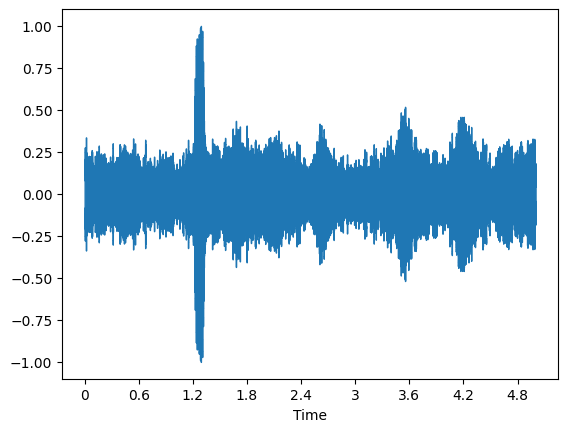

In [ ]:
librosa.display.waveshow(audio_aug, sr=sr)

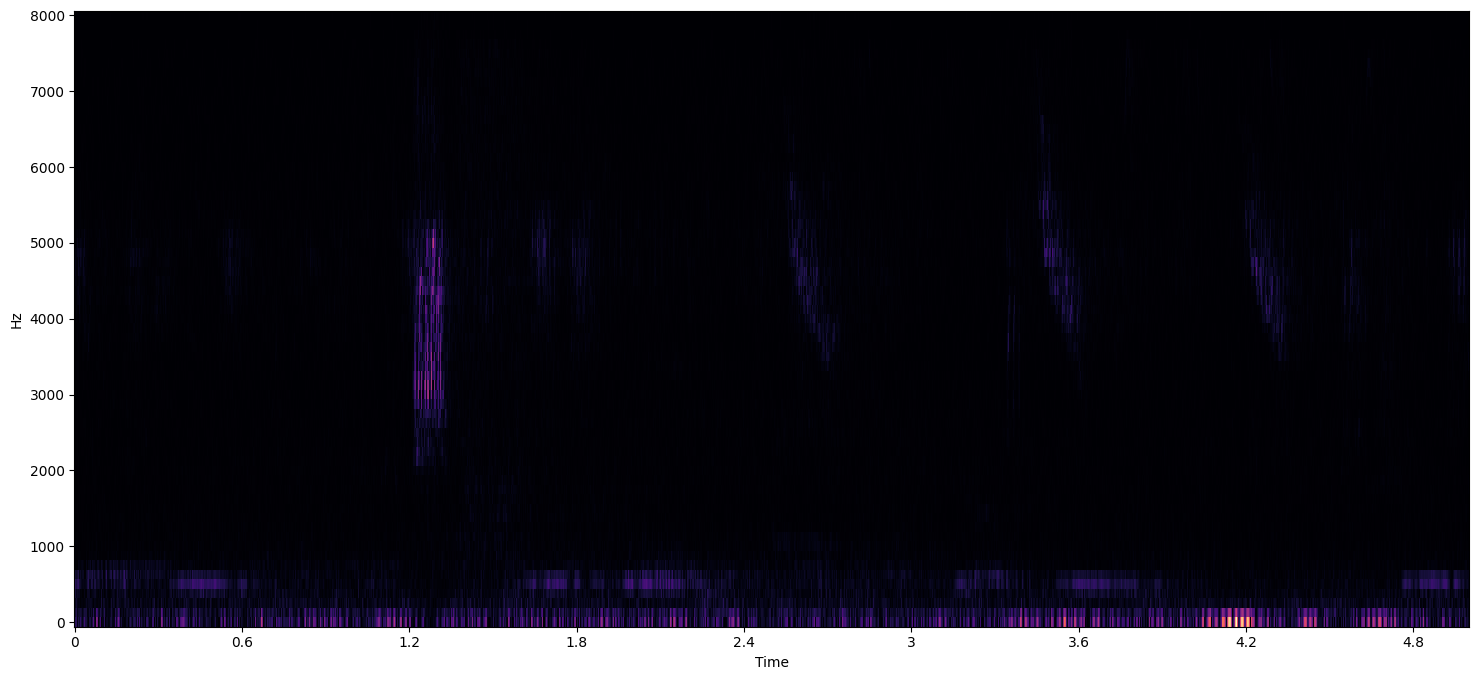

In [ ]:
S = np.abs(librosa.stft(audio_aug, n_fft=128, hop_length=32))
spec_min, spec_max = np.min(S), np.max(S)
spec_range = spec_max - spec_min
spec_minmax = (S - spec_min) / spec_range
plt.figure(figsize=(18,8))
librosa.display.specshow(
    spec_minmax
    , x_axis='time'
    , y_axis='linear'
    , sr=sr
    , hop_length=32
)

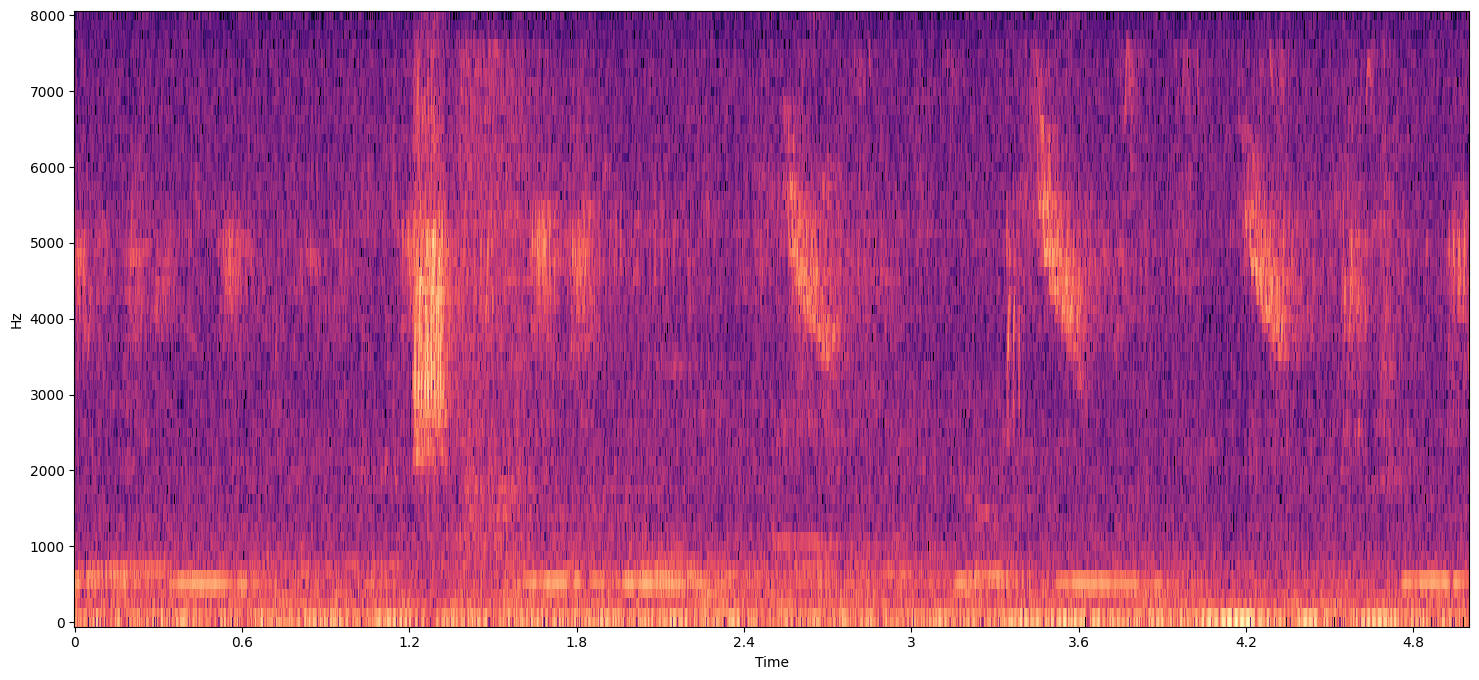

In [ ]:
# S = np.abs(librosa.stft(librosa.mu_compress(audio_clip, mu=127, quantize=False), n_fft=128, hop_length=32))

S_db = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize=(18,8))
librosa.display.specshow(
    S_db
    , x_axis='time'
    , y_axis='linear'
    , sr=sr
    , hop_length=32
)

In [ ]:
freqs, times, mags = librosa.reassigned_spectrogram(y=audio_aug, sr=sr, n_fft=128, hop_length=16, ref_power=1e-1)
mags_db = librosa.amplitude_to_db(mags, ref=np.max)

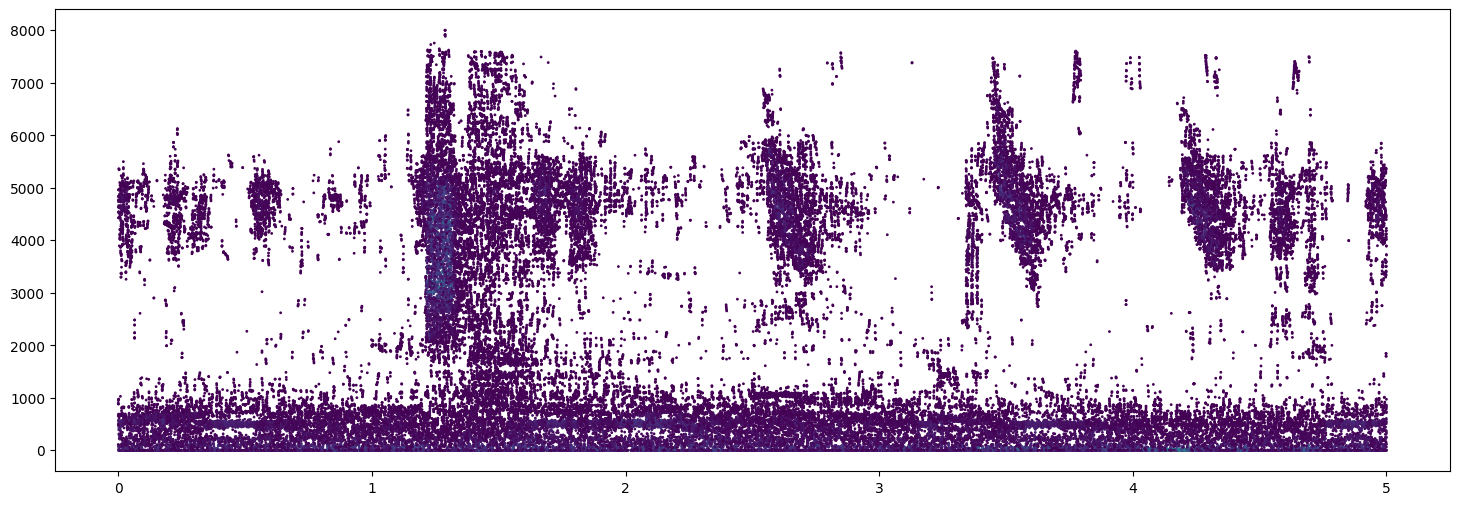

In [ ]:
plt.figure(figsize=(18,6))
plt.scatter(times, freqs, c=mags, s=1)

In [ ]:
np.sum(~np.isnan(times))

72303

In [ ]:
65*2501

162565

In [ ]:
# S_med = librosa.decompose.nn_filter(S, aggregate=np.median, axis=0)
# S_med_db = librosa.amplitude_to_db(S_med, ref=np.max)
# plt.figure(figsize=(18,8))
# librosa.display.specshow(
#     S_med_db
#     , x_axis='time'
#     , y_axis='linear'
#     , sr=sr
#     , hop_length=32
# )

In [ ]:
S.shape

(65, 2501)

In [ ]:
print(np.min(S), np.max(S), np.mean(S))
print(np.min(S_db), np.max(S_db), np.mean(S_db))

4.0627248e-07 10.242829 0.25617495
-80.0 0.0 -40.982864


In [ ]:
nmf = NMF(n_components=4, max_iter=500, verbose=0)
# nmf = NMF(n_components=8, max_iter=300, beta_loss='kullback-leibler', solver='mu', verbose=0)
comps, acts = librosa.decompose.decompose(S, transformer=nmf)
# comps, acts = librosa.decompose.decompose(S, n_components=8, sort=True)
print(f'spectrogram: {S.shape}')
print(f'components: {comps.shape}')
print(f'activations: {acts.shape}')
print()
print(f'spectrogram # weights: {len(S.flatten())}')
print(f'decomp # weights: {len(comps.flatten()) + len(acts.flatten())}')

spectrogram: (65, 2501)
components: (65, 4)
activations: (4, 2501)

spectrogram # weights: 162565
decomp # weights: 10264


In [ ]:
np.median(acts)

0.006590308

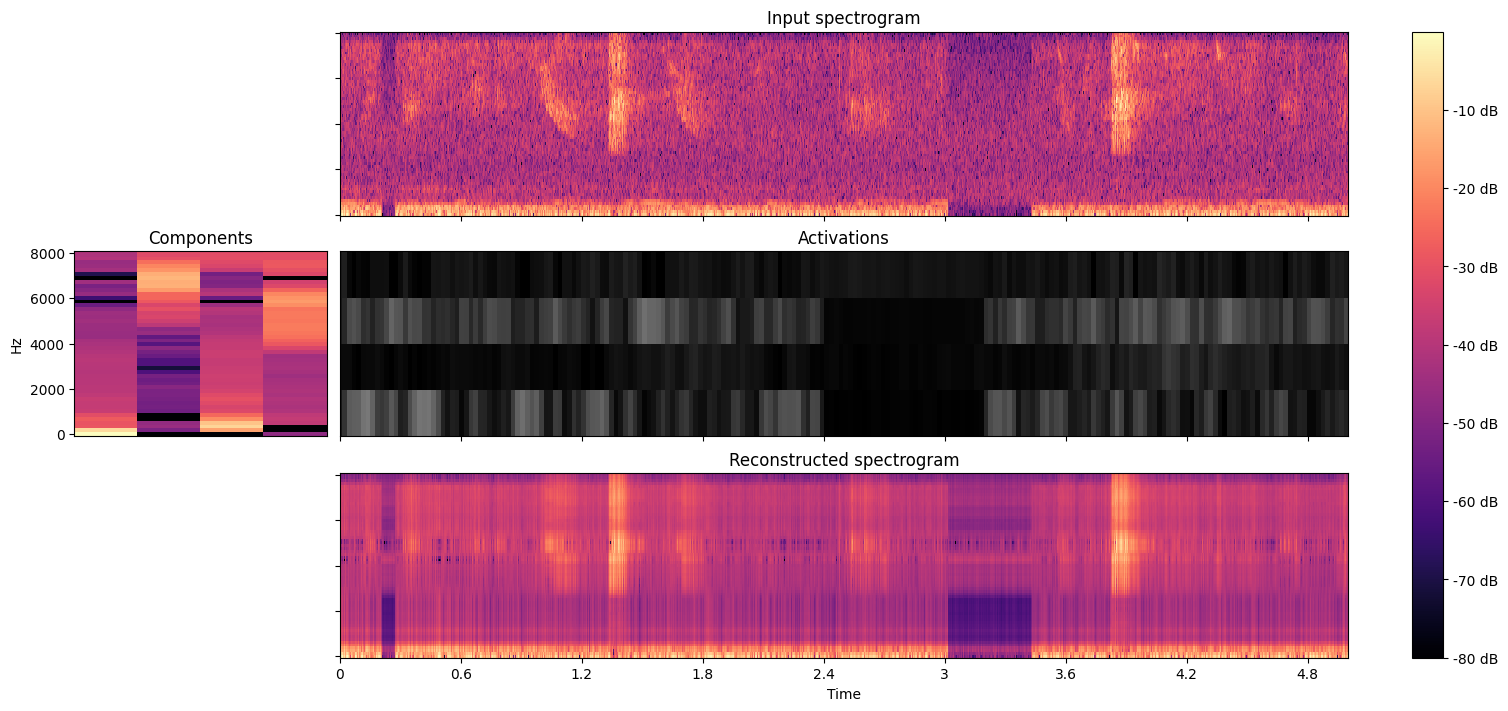

In [ ]:
layout = [list(".AAAA"), list("BCCCC"), list(".DDDD")]
fig, ax = plt.subplot_mosaic(layout, constrained_layout=True, figsize=(15, 7))
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='linear', x_axis='time', sr=sr, hop_length=32, ax=ax['A'])
ax['A'].set(title='Input spectrogram')
ax['A'].label_outer()
librosa.display.specshow(librosa.amplitude_to_db(comps,
                                                 ref=np.max),
                         y_axis='linear', hop_length=32, ax=ax['B'])
ax['B'].set(title='Components')
ax['B'].label_outer()
ax['B'].sharey(ax['A'])
#librosa.display.specshow(librosa.amplitude_to_db(acts, ref=np.max), x_axis='time', ax=ax['C'], cmap='gray')
librosa.display.specshow(acts ** 0.75, x_axis='time', ax=ax['C'], cmap='gray')
ax['C'].set(ylabel='Components', title='Activations')
ax['C'].sharex(ax['A'])
ax['C'].label_outer()
S_approx = comps.dot(acts)
img = librosa.display.specshow(librosa.amplitude_to_db(S_approx,
                                                       ref=np.max),
                               y_axis='linear', x_axis='time', sr=sr, hop_length=32, ax=ax['D'])
ax['D'].set(title='Reconstructed spectrogram')
ax['D'].sharex(ax['A'])
ax['D'].sharey(ax['A'])
ax['D'].label_outer()
fig.colorbar(img, ax=list(ax.values()), format="%+2.f dB")

In [ ]:
audio_approx = librosa.griffinlim(S_approx, n_iter=256)
audio_approx

array([ 0.00273044,  0.04189423,  0.01047399, ..., -0.01954192,
        0.06151311,  0.04658046], dtype=float32)

In [ ]:
len(audio_approx)

80000

In [ ]:
Audio(audio_approx, rate=sr)

# Prepare train metadata

In [272]:
train_meta_df

primary_label          common_name    scientific_name  species_rank  \
0          thrnig1   Thrush Nightingale  Luscinia luscinia             0   
1          thrnig1   Thrush Nightingale  Luscinia luscinia             0   
2          thrnig1   Thrush Nightingale  Luscinia luscinia             0   
3          thrnig1   Thrush Nightingale  Luscinia luscinia             0   
4          thrnig1   Thrush Nightingale  Luscinia luscinia             0   
...            ...                  ...                ...           ...   
3273       cohmar1  Common House-Martin   Delichon urbicum             9   
3274       cohmar1  Common House-Martin   Delichon urbicum             9   
3275       cohmar1  Common House-Martin   Delichon urbicum             9   
3276       cohmar1  Common House-Martin   Delichon urbicum             9   
3277       cohmar1  Common House-Martin   Delichon urbicum             9   

                  filename dataset  duration_secs  duration_mins  \
0     thrnig1/XC110335.ogg   train     119.275102       1.987918   
1     thrnig1/XC110336.ogg   train     122.044127       2.034069   
2     thrnig1/XC118260.ogg   train      44.382041       0.739701   
3     thrnig1/XC120947.ogg   train     189.231066       3.153851   
4     thrnig1/XC125024.ogg   train      45.312018       0.755200   
...                    ...     ...            ...            ...   
3273  cohmar1/XC748724.ogg   train      54.909025       0.915150   
3274  cohmar1/XC748726.ogg   train       6.974694       0.116245   
3275  cohmar1/XC749483.ogg   train      20.950249       0.349171   
3276  cohmar1/XC749638.ogg   train       6.984036       0.116401   
3277  cohmar1/XC751198.ogg   train      17.266032       0.287767   

      duration_hrs  species_total_files  species_train_files  \
0         0.033132                  499                  349   
1         0.033901                  499                  349   
2         0.012328                  499                  349   
3         0.052564                  499                  349   
4         0.012587                  499                  349   
...            ...                  ...                  ...   
3273      0.015253                  408                  286   
3274      0.001937                  408                  286   
3275      0.005820                  408                  286   
3276      0.001940                  408                  286   
3277      0.004796                  408                  286   

      species_test_files  species_total_duration_hrs  \
0                    150                   17.078735   
1                    150                   17.078735   
2                    150                   17.078735   
3                    150                   17.078735   
4                    150                   17.078735   
...                  ...                         ...   
3273                 122                    5.656965   
3274                 122                    5.656965   
3275                 122                    5.656965   
3276                 122                    5.656965   
3277                 122                    5.656965   

      species_train_duration_hrs  species_test_duration_hrs  total_files  \
0                      10.739077                   6.339658         4680   
1                      10.739077                   6.339658         4680   
2                      10.739077                   6.339658         4680   
3                      10.739077                   6.339658         4680   
4                      10.739077                   6.339658         4680   
...                          ...                        ...          ...   
3273                    4.103189                   1.553775         4680   
3274                    4.103189                   1.553775         4680   
3275                    4.103189                   1.553775         4680   
3276                    4.103189                   1.553775         4680 

In [274]:
train_meta_df.columns

Index(['primary_label', 'common_name', 'scientific_name', 'species_rank',
       'filename', 'dataset', 'duration_secs', 'duration_mins', 'duration_hrs',
       'species_total_files', 'species_train_files', 'species_test_files',
       'species_total_duration_hrs', 'species_train_duration_hrs',
       'species_test_duration_hrs', 'total_files', 'train_files', 'test_files',
       'total_duration_hrs', 'train_duration_hrs', 'test_duration_hrs',
       'filename_npy', 'type', 'secondary_labels', 'rating', 'latitude',
       'longitude', 'author', 'url', 'license', 'class_weight_file',
       'class_weight_duration', 'class_weight_combined', 'orig_index'],
      dtype='object')

In [276]:
train_meta_df_2 = train_meta_df[[
    'species_rank'
    , 'primary_label'
    , 'common_name'
    , 'filename_npy'
    , 'rating'
    , 'duration_secs'
]]
train_meta_df_2

species_rank primary_label          common_name          filename_npy  \
0                0       thrnig1   Thrush Nightingale  thrnig1/XC110335.npy   
1                0       thrnig1   Thrush Nightingale  thrnig1/XC110336.npy   
2                0       thrnig1   Thrush Nightingale  thrnig1/XC118260.npy   
3                0       thrnig1   Thrush Nightingale  thrnig1/XC120947.npy   
4                0       thrnig1   Thrush Nightingale  thrnig1/XC125024.npy   
...            ...           ...                  ...                   ...   
3273             9       cohmar1  Common House-Martin  cohmar1/XC748724.npy   
3274             9       cohmar1  Common House-Martin  cohmar1/XC748726.npy   
3275             9       cohmar1  Common House-Martin  cohmar1/XC749483.npy   
3276             9       cohmar1  Common House-Martin  cohmar1/XC749638.npy   
3277             9       cohmar1  Common House-Martin  cohmar1/XC751198.npy   

      rating  duration_secs  
0        4.5     119.275102  
1        5.0     122.044127  
2        5.0      44.382041  
3        4.5     189.231066  
4        2.5      45.312018  
...      ...            ...  
3273     1.0      54.909025  
3274     1.0       6.974694  
3275     5.0      20.950249  
3276     3.5       6.984036  
3277     5.0      17.266032  

[3278 rows x 6 columns]

In [279]:
def assign_datasets(meta_df, val_ratio=0.2, random_seed=207):
  rng = np.random.default_rng(seed=random_seed)
  df_list = []

  # Loop through each species' corresponding DataFrame
  for species_group in meta_df.groupby('primary_label'):
    species_df = species_group[1].copy()
    species_df['dataset'] = 'train'
    # Determine total file number & target test file number
    n_files = len(species_df)
    n_test_files = int(n_files * val_ratio)
    # Make random choices for the test set
    test_indices = rng.choice(n_files, n_test_files, replace=False)
    test_indices.sort()
    species_df['dataset'].iloc[test_indices] = 'val'
    df_list.append(species_df)

  return pd.concat(df_list)

In [287]:
train_val_df = assign_datasets(train_meta_df_2, 0.15, 207)
train_val_df

<ipython-input-279-216dd78a97dc>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  species_df['dataset'].iloc[test_indices] = 'val'
<ipython-input-279-216dd78a97dc>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  species_df['dataset'].iloc[test_indices] = 'val'
<ipython-input-279-216dd78a97dc>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  species_df['dataset'].iloc[test_indices] = 'val'
<ipython-input-279-216dd78a97dc>:15: Settin

species_rank primary_label     common_name         filename_npy  rating  \
1396             4        barswa    Barn Swallow  barswa/XC132406.npy     3.0   
1397             4        barswa    Barn Swallow  barswa/XC133802.npy     3.0   
1398             4        barswa    Barn Swallow  barswa/XC134349.npy     5.0   
1399             4        barswa    Barn Swallow  barswa/XC135474.npy     4.0   
1400             4        barswa    Barn Swallow  barswa/XC139171.npy     5.0   
...            ...           ...             ...                  ...     ...   
2070             5        woosan  Wood Sandpiper  woosan/XC747319.npy     2.5   
2071             5        woosan  Wood Sandpiper  woosan/XC749070.npy     4.0   
2072             5        woosan  Wood Sandpiper  woosan/XC754702.npy     5.0   
2073             5        woosan  Wood Sandpiper  woosan/XC754765.npy     5.0   
2074             5        woosan  Wood Sandpiper  woosan/XC754766.npy     4.0   

      duration_secs dataset  
1396      10.788571     val  
1397      15.490658   train  
1398     104.437596   train  
1399      13.270249   train  
1400       5.040000   train  
...             ...     ...  
2070      10.605760   train  
2071      18.384036   train  
2072      58.546440   train  
2073      71.276780     val  
2074      23.084671   train  

[3278 rows x 7 columns]

In [288]:
train_val_df.value_counts(subset=['species_rank', 'dataset']).sort_index()

species_rank  dataset
0             train      297
              val         52
1             train      298
              val         52
2             train      296
              val         52
3             train      297
              val         52
4             train      295
              val         52
5             train      283
              val         49
6             train      283
              val         49
7             train      250
              val         43
8             train      249
              val         43
9             train      244
              val         42
dtype: int64

In [291]:
train_df = train_val_df[train_val_df['dataset'] == 'train'].copy()
val_df = train_val_df[train_val_df['dataset'] == 'val'].copy()

In [296]:
train_df.sort_values(by=['species_rank', 'filename_npy'], inplace=True)
train_df.reset_index(drop=True, inplace=True)
train_df

species_rank primary_label          common_name          filename_npy  \
0                0       thrnig1   Thrush Nightingale  thrnig1/XC110335.npy   
1                0       thrnig1   Thrush Nightingale  thrnig1/XC110336.npy   
2                0       thrnig1   Thrush Nightingale  thrnig1/XC118260.npy   
3                0       thrnig1   Thrush Nightingale  thrnig1/XC125024.npy   
4                0       thrnig1   Thrush Nightingale  thrnig1/XC129509.npy   
...            ...           ...                  ...                   ...   
2787             9       cohmar1  Common House-Martin  cohmar1/XC748723.npy   
2788             9       cohmar1  Common House-Martin  cohmar1/XC748724.npy   
2789             9       cohmar1  Common House-Martin  cohmar1/XC748726.npy   
2790             9       cohmar1  Common House-Martin  cohmar1/XC749638.npy   
2791             9       cohmar1  Common House-Martin  cohmar1/XC751198.npy   

      rating  duration_secs dataset  
0        4.5     119.275102   train  
1        5.0     122.044127   train  
2        5.0      44.382041   train  
3        2.5      45.312018   train  
4        5.0     108.288027   train  
...      ...            ...     ...  
2787     2.0      41.351882   train  
2788     1.0      54.909025   train  
2789     1.0       6.974694   train  
2790     3.5       6.984036   train  
2791     5.0      17.266032   train  

[2792 rows x 7 columns]

In [297]:
val_df.sort_values(by=['species_rank', 'filename_npy'], inplace=True)
val_df.reset_index(drop=True, inplace=True)
val_df

species_rank primary_label          common_name          filename_npy  \
0               0       thrnig1   Thrush Nightingale  thrnig1/XC120947.npy   
1               0       thrnig1   Thrush Nightingale  thrnig1/XC132244.npy   
2               0       thrnig1   Thrush Nightingale  thrnig1/XC144543.npy   
3               0       thrnig1   Thrush Nightingale  thrnig1/XC149938.npy   
4               0       thrnig1   Thrush Nightingale  thrnig1/XC176618.npy   
..            ...           ...                  ...                   ...   
481             9       cohmar1  Common House-Martin  cohmar1/XC730813.npy   
482             9       cohmar1  Common House-Martin  cohmar1/XC738906.npy   
483             9       cohmar1  Common House-Martin  cohmar1/XC742048.npy   
484             9       cohmar1  Common House-Martin  cohmar1/XC747155.npy   
485             9       cohmar1  Common House-Martin  cohmar1/XC749483.npy   

     rating  duration_secs dataset  
0       4.5     189.231066     val  
1       3.5     164.336327     val  
2       3.5      27.167347     val  
3       5.0      20.898005     val  
4       4.0      97.280000     val  
..      ...            ...     ...  
481     5.0      74.736009     val  
482     4.0      28.081043     val  
483     5.0       5.146032     val  
484     4.5      50.860408     val  
485     5.0      20.950249     val  

[486 rows x 7 columns]

In [299]:
val_df.iloc[4]

species_rank                        0
primary_label                 thrnig1
common_name        Thrush Nightingale
filename_npy     thrnig1/XC176618.npy
rating                            4.0
duration_secs                   97.28
dataset                           val
Name: 4, dtype: object

In [328]:
val_recs = len(val_df)
val_frame_length = 80000

val_rec_list = []
val_labels = np.zeros((val_recs, ), dtype=np.uint8)
val_audio = np.zeros((val_recs, val_frame_length), dtype=np.float32)

In [329]:
for i in range(val_recs):
  val_rec = val_df.iloc[i]
  val_labels[i] = val_rec['species_rank']

  file_path = gdi.get_sample_path('train_npy_full', val_rec['filename_npy'])
  clip_dict = load_random_npy_clip(file_path)
  val_audio[i, :] = clip_dict.pop('clip')

  val_rec_list.append(clip_dict)


In [335]:
val_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [334]:
val_audio

array([[ 8.6484000e-04,  3.3521245e-04,  1.5602361e-03, ...,
        -2.4077727e-03,  2.7673249e-03,  3.2092787e-03],
       [ 3.3105956e-04, -1.5096295e-03,  1.7012208e-04, ...,
         1.5478495e-03,  2.6778644e-04, -8.9547999e-04],
       [ 4.8279716e-04,  5.7400581e-03, -2.8634123e-03, ...,
        -5.3322064e-03, -5.0448403e-03, -1.1035129e-03],
       ...,
       [ 2.7300848e-07,  4.3932610e-06,  2.1893602e-06, ...,
        -7.3666153e-03, -7.0430916e-03, -7.6735271e-03],
       [-1.9575149e-04,  8.0588658e-04,  3.5802671e-03, ...,
        -2.5908051e-03,  5.0250487e-03,  2.1165612e-03],
       [ 2.0825644e-03,  1.0723767e-03, -1.3370237e-02, ...,
         9.1609024e-03,  8.2144048e-03,  3.2243086e-03]], dtype=float32)

In [331]:
val_clip_df = pd.DataFrame(val_rec_list)
val_clip_df

sr   frames         clip_frames        secs                 clip_secs
0    16000  3027697    (908628, 988628)  189.231063      (56.78925, 61.78925)
1    16000  2629381  (1466664, 1546664)  164.336312        (91.6665, 96.6665)
2    16000   434678    (104914, 184914)   27.167375     (6.557125, 11.557125)
3    16000   334368      (18269, 98269)   20.898000    (1.1418125, 6.1418125)
4    16000  1556480    (316455, 396455)   97.280000  (19.7784375, 24.7784375)
..     ...      ...                 ...         ...                       ...
481  16000  1195776  (1105611, 1185611)   74.736000  (69.1006875, 74.1006875)
482  16000   449296    (114527, 194527)   28.081000   (7.1579375, 12.1579375)
483  16000    82336        (183, 80183)    5.146000    (0.0114375, 5.0114375)
484  16000   813767    (705710, 785710)   50.860438    (44.106875, 49.106875)
485  16000   335204     (54860, 134860)   20.950250        (3.42875, 8.42875)

[486 rows x 5 columns]

In [338]:
val_df_final = pd.concat([val_df, val_clip_df], axis=1)
val_df_final

species_rank primary_label          common_name          filename_npy  \
0               0       thrnig1   Thrush Nightingale  thrnig1/XC120947.npy   
1               0       thrnig1   Thrush Nightingale  thrnig1/XC132244.npy   
2               0       thrnig1   Thrush Nightingale  thrnig1/XC144543.npy   
3               0       thrnig1   Thrush Nightingale  thrnig1/XC149938.npy   
4               0       thrnig1   Thrush Nightingale  thrnig1/XC176618.npy   
..            ...           ...                  ...                   ...   
481             9       cohmar1  Common House-Martin  cohmar1/XC730813.npy   
482             9       cohmar1  Common House-Martin  cohmar1/XC738906.npy   
483             9       cohmar1  Common House-Martin  cohmar1/XC742048.npy   
484             9       cohmar1  Common House-Martin  cohmar1/XC747155.npy   
485             9       cohmar1  Common House-Martin  cohmar1/XC749483.npy   

     rating  duration_secs dataset     sr   frames         clip_frames  \
0       4.5     189.231066     val  16000  3027697    (908628, 988628)   
1       3.5     164.336327     val  16000  2629381  (1466664, 1546664)   
2       3.5      27.167347     val  16000   434678    (104914, 184914)   
3       5.0      20.898005     val  16000   334368      (18269, 98269)   
4       4.0      97.280000     val  16000  1556480    (316455, 396455)   
..      ...            ...     ...    ...      ...                 ...   
481     5.0      74.736009     val  16000  1195776  (1105611, 1185611)   
482     4.0      28.081043     val  16000   449296    (114527, 194527)   
483     5.0       5.146032     val  16000    82336        (183, 80183)   
484     4.5      50.860408     val  16000   813767    (705710, 785710)   
485     5.0      20.950249     val  16000   335204     (54860, 134860)   

           secs                 clip_secs  
0    189.231063      (56.78925, 61.78925)  
1    164.336312        (91.6665, 96.6665)  
2     27.167375     (6.557125, 11.557125)  
3     20.898000    (1.1418125, 6.1418125)  
4     97.280000  (19.7784375, 24.7784375)  
..          ...                       ...  
481   74.736000  (69.1006875, 74.1006875)  
482   28.081000   (7.1579375, 12.1579375)  
483    5.146000    (0.0114375, 5.0114375)  
484   50.860438    (44.106875, 49.106875)  
485   20.950250        (3.42875, 8.42875)  

[486 rows x 12 columns]

In [337]:
np.save(file=gdi.join_to_shared('data/train/val_labels'), arr=val_labels)
np.save(file=gdi.join_to_shared('data/train/val_audio'), arr=val_audio)

In [339]:
val_df_final.to_csv(
    path_or_buf=gdi.join_to_shared('data/train/val_meta_df.csv')
    , index=False
)

In [22]:
train_df['perc_of_train_hrs'] = train_df['duration_secs'] / ( 60 * 60 * train_df['train_duration_hrs'])
train_df

<ipython-input-22-481eea9b42a7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['perc_of_train_hrs'] = train_df['duration_secs'] / ( 60 * 60 * train_df['train_duration_hrs'])


species_rank              filename  duration_secs  train_duration_hrs  \
0                0  thrnig1/XC110335.ogg     119.275102           49.463144   
1                0  thrnig1/XC110336.ogg     122.044127           49.463144   
2                0  thrnig1/XC118260.ogg      44.382041           49.463144   
3                0  thrnig1/XC120947.ogg     189.231066           49.463144   
4                0  thrnig1/XC125024.ogg      45.312018           49.463144   
...            ...                   ...            ...                 ...   
3273             9  cohmar1/XC748724.ogg      54.909025           49.463144   
3274             9  cohmar1/XC748726.ogg       6.974694           49.463144   
3275             9  cohmar1/XC749483.ogg      20.950249           49.463144   
3276             9  cohmar1/XC749638.ogg       6.984036           49.463144   
3277             9  cohmar1/XC751198.ogg      17.266032           49.463144   

      perc_of_train_hrs  
0              0.000670  
1              0.000685  
2              0.000249  
3              0.001063  
4              0.000254  
...                 ...  
3273           0.000308  
3274           0.000039  
3275           0.000118  
3276           0.000039  
3277           0.000097  

[3278 rows x 5 columns]

In [23]:
train_df['filepath'] = train_df['filename'].apply(
    lambda x: gdi.get_sample_path('train_audio', x)
)
train_df

<ipython-input-23-8b0e4bd99b92>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['filepath'] = train_df['filename'].apply(


species_rank              filename  duration_secs  train_duration_hrs  \
0                0  thrnig1/XC110335.ogg     119.275102           49.463144   
1                0  thrnig1/XC110336.ogg     122.044127           49.463144   
2                0  thrnig1/XC118260.ogg      44.382041           49.463144   
3                0  thrnig1/XC120947.ogg     189.231066           49.463144   
4                0  thrnig1/XC125024.ogg      45.312018           49.463144   
...            ...                   ...            ...                 ...   
3273             9  cohmar1/XC748724.ogg      54.909025           49.463144   
3274             9  cohmar1/XC748726.ogg       6.974694           49.463144   
3275             9  cohmar1/XC749483.ogg      20.950249           49.463144   
3276             9  cohmar1/XC749638.ogg       6.984036           49.463144   
3277             9  cohmar1/XC751198.ogg      17.266032           49.463144   

      perc_of_train_hrs  \
0              0.000670   
1              0.000685   
2              0.000249   
3              0.001063   
4              0.000254   
...                 ...   
3273           0.000308   
3274           0.000039   
3275           0.000118   
3276           0.000039   
3277           0.000097   

                                                                            filepath  
0     /content/drive/MyDrive/207-Project/data/train/audio_files/thrnig1/XC110335.ogg  
1     /content/drive/MyDrive/207-Project/data/train/audio_files/thrnig1/XC110336.ogg  
2     /content/drive/MyDrive/207-Project/data/train/audio_files/thrnig1/XC118260.ogg  
3     /content/drive/MyDrive/207-Project/data/train/audio_files/thrnig1/XC120947.ogg  
4     /content/drive/MyDrive/207-Project/data/train/audio_files/thrnig1/XC125024.ogg  
...                                                                              ...  
3273  /content/drive/MyDrive/207-Project/data/train/audio_files/cohmar1/XC748724.ogg  
3274  /content/drive/MyDrive/207-Project/data/train/audio_files/cohmar1/XC748726.ogg  
3275  /content/drive/MyDrive/207-Project/data/train/audio_files/cohmar1/XC749483.ogg  
3276  /content/drive/MyDrive/207-Project/data/train/audio_files/cohmar1/XC749638.ogg  
3277  /content/drive/MyDrive/207-Project/data/train/audio_files/cohmar1/XC751198.ogg  

[3278 rows x 6 columns]

# Define Data Loader

In [24]:
train_idx = np.array(train_df.index)
train_labels = np.array(train_df['species_rank'])
train_filepaths = list(train_df['filepath'])
train_durations = np.array(train_df['duration_secs'])
train_probs = np.array(train_df['perc_of_train_hrs'])

print(train_idx)
print(train_labels)
print(train_filepaths[:2])
print(train_durations)
print(train_probs)

[   0    1    2 ... 3275 3276 3277]
[0 0 0 ... 9 9 9]
['/content/drive/MyDrive/207-Project/data/train/audio_files/thrnig1/XC110335.ogg', '/content/drive/MyDrive/207-Project/data/train/audio_files/thrnig1/XC110336.ogg']
[119.27510204 122.04412698  44.38204082 ...  20.95024943   6.98403628
  17.26603175]
[6.69831519e-04 6.85381958e-04 2.49243047e-04 ... 1.17653535e-04
 3.92213258e-05 9.69635077e-05]


In [25]:
augment_audio = am.Compose([
    am.Normalize(p=1.0)
    , am.OneOf([
        am.Lambda(transform=audio_compress, mu_min=1, mu_max=9, p=0.5)
        , am.Lambda(transform=audio_expand, mu_min=1, mu_max=9, p=0.5)
    ])
    , am.SevenBandParametricEQ(min_gain_db=-12.0, max_gain_db=12.0, p=0.5)
    , am.Normalize(p=1.0)
    , am.Lambda(transform=add_silent_frames, p=0.25)
    # , am.TimeMask(0.1, 0.2, p=0.5)
    # , am.TimeMask(0.05, 0.1, p=0.5)
    # , am.TimeMask(0.025, 0.05, p=0.5)
    # , am.TimeMask(0.01, 0.02, p=0.5)
    # , am.TimeMask(0.01, 0.02, p=0.5)
    # , am.TimeMask(0.01, 0.02, p=0.5)
    , am.Lambda(
        transform=add_colored_noise2
        , min_gain_db=-12.0
        , max_gain_db=12.0
        , scale_min=0.005
        , scale_max=0.05
        , p=0.5
    )
    , am.Normalize(p=1.0)
    , am.Lambda(transform=add_crackle, p=0.25)
])

In [26]:
def audio_generator(idx
                    , labels
                    , filepaths
                    , durations
                    , files_per_batch=8
                    , batch_size=64
                    , prob_smoothing=0.0
                    , clip_length=5.0
                    , target_sr=16000
                    , n_fft=128
                    , hop_length=32
                    , min_freq=250
                    , augment=False
                    ):
  clip_samples = int(clip_length * target_sr)
  fft_freqs = librosa.fft_frequencies(sr=target_sr, n_fft=n_fft)
  fft_freqs_valid = fft_freqs[fft_freqs >= min_freq]
  spec_fdim = len(fft_freqs_valid)
  spec_fstart = len(fft_freqs) - spec_fdim
  # spec_fdim = n_fft // 2 + 1
  spec_tdim = clip_samples // hop_length + 1

  ch_idx = np.random.choice(idx, size=files_per_batch)
  ch_labels = labels[ch_idx]
  ch_paths = [filepaths[i] for i in ch_idx]
  ch_durs = durations[ch_idx]
  ch_probs = ch_durs / np.sum(ch_durs)
  if prob_smoothing != 0.0:
    unif_probs = np.ones_like(ch_probs) / float(files_per_batch)
    ch_probs = (prob_smoothing * unif_probs) + ((1.0 - prob_smoothing) * ch_probs)

  # print(ch_idx)
  # print(ch_labels)
  # for path in ch_paths:
  #   print(path)
  # print(ch_durs)
  # print(ch_probs)
  # print(np.sum(ch_probs))

  jdx = np.arange(files_per_batch)
  batch_jdx = np.random.choice(jdx, size=batch_size, p=ch_probs)
  batch_labels = np.zeros((batch_size, ), dtype=np.uint8)
  batch_filepaths = []
  batch_segments = []
  batch_audio = np.zeros((batch_size, clip_samples), dtype=np.float32)
  batch_audio_aug = np.zeros((batch_size, clip_samples), dtype=np.float32)
  batch_spec = np.zeros((batch_size, spec_fdim, spec_tdim), dtype=np.float32)
  batch_spec_db = np.zeros((batch_size, spec_fdim, spec_tdim), dtype=np.float32)

  for j in range(batch_size):
    sel_jdx = batch_jdx[j]
    batch_labels[j] = ch_labels[sel_jdx]
    filepath = ch_paths[sel_jdx]
    batch_filepaths.append(filepath)
    audio, sr, segment = load_random_clip(
        file_path = filepath
        , file_duration = ch_durs[sel_jdx]
        , clip_secs=clip_length
    )
    batch_segments.append(segment)
    audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
    audio -= np.mean(audio)
    batch_audio[j,:] = audio

    if augment:
      audio_aug = augment_audio(audio, sr)
      batch_audio_aug[j,:] = audio_aug
    else:
      batch_audio_aug[j,:] = audio

    stft = librosa.stft(audio_aug, n_fft=n_fft, hop_length=hop_length)[spec_fstart:,]
    spec = np.abs(stft)
    spec_min, spec_max = np.min(spec), np.max(spec)
    spec_range = spec_max - spec_min
    spec_minmax = (spec - spec_min) / spec_range
    batch_spec[j,:,:] = spec_minmax

    spec_db = librosa.amplitude_to_db(spec, ref=np.max)
    # spec_db_sc = spec_db - np.repeat(np.mean(spec_db, axis=1).reshape(-1,1), spec_tdim, axis=1)
    spec_db_sc = spec_db - np.mean(spec_db)
    spec_db_sc /= np.std(spec_db_sc)
    batch_spec_db[j,:,:] = spec_db_sc

  return batch_labels, batch_filepaths, batch_segments, batch_audio, batch_audio_aug, batch_spec, batch_spec_db, fft_freqs_valid


# Pull sample batch

In [27]:
sample_labels, sample_filepaths, sample_segments, sample_audios, sample_aug_audios, sample_specs, sample_db_specs, fft_freqs = audio_generator(
    train_idx
    , train_labels
    , train_filepaths
    , train_durations
    , files_per_batch=32
    , batch_size=64
    , prob_smoothing=0.5
    , clip_length=5.0
    , target_sr=16000
    , n_fft=128
    , hop_length=32
    , min_freq=250
    , augment=True
    )

/usr/local/lib/python3.10/dist-packages/audiomentations/core/transforms_interface.py:61: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(


In [27]:
sample_db_specs.shape

(64, 63, 2501)

In [ ]:
# np.save(gdi.join_to_shared('data/test_feature_out'), specs)

In [357]:
batch_item = 4
sample_label = sample_labels[batch_item]
sample_filepath = sample_filepaths[batch_item]
sample_segment = sample_segments[batch_item]
sample_audio = sample_audios[batch_item,:]
sample_audio_aug = sample_aug_audios[batch_item,:]
sample_spec = sample_specs[batch_item, :, :]
sample_spec_db = sample_db_specs[batch_item, :, :]

print(f'label: {sample_label}')
print(f'file: {sample_filepath}')
print(f'segment: {sample_segment}')
# Audio(sample_audio, rate=16000, autoplay=True)

label: 3
file: /content/drive/MyDrive/207-Project/data/train/audio_files/comsan/XC669042.ogg
segment: (1.65641040504295, 6.65641040504295)


In [303]:
Audio(sample_audio, rate=16000, autoplay=True)

In [304]:
Audio(sample_audio_aug, rate=16000, autoplay=True)

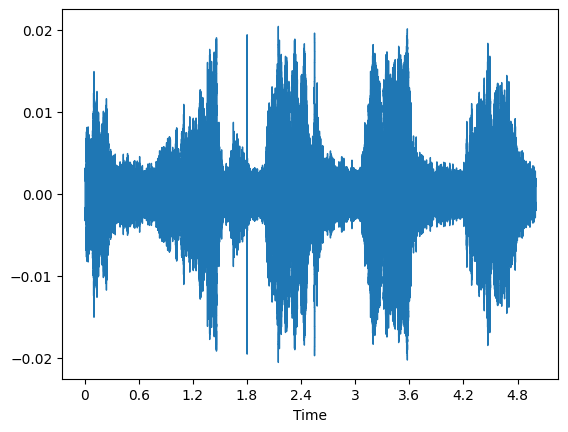

In [358]:
librosa.display.waveshow(sample_audio, sr=16000)

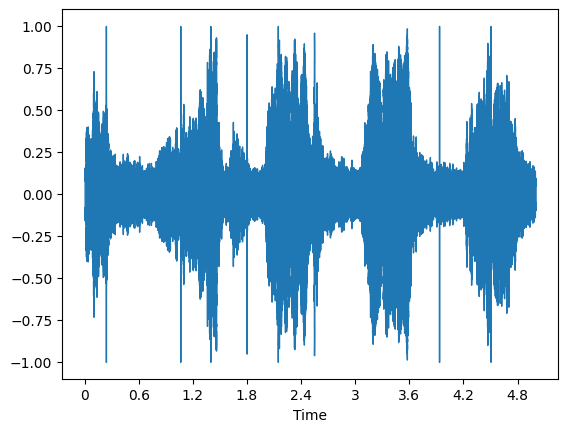

In [359]:
librosa.display.waveshow(sample_audio_aug, sr=16000)

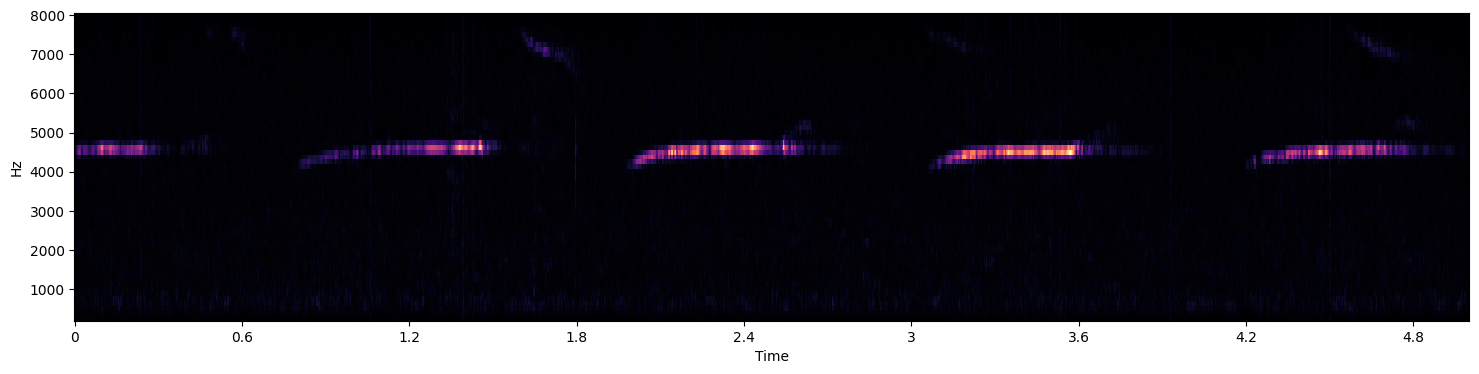

In [360]:
# S = np.abs(librosa.stft(sample_audio, n_fft=128, hop_length=32))
# S_db = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize=(18,4))
librosa.display.specshow(
    sample_spec
    , x_axis='time'
    , y_axis='linear'
    , y_coords=fft_freqs
    , sr=16000
    , hop_length=32
)

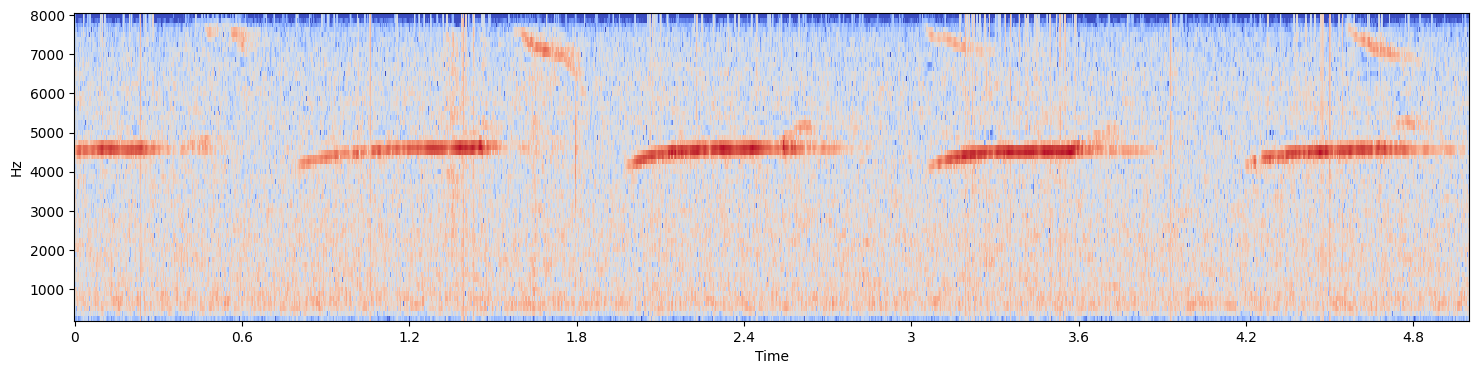

In [361]:
# S = np.abs(librosa.stft(sample_audio, n_fft=128, hop_length=32))
# S_db = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize=(18,4))
librosa.display.specshow(
    sample_spec_db
    , x_axis='time'
    , y_axis='linear'
    , y_coords=fft_freqs
    , sr=16000
    , hop_length=32
)

In [ ]:
sample_spec_db.shape

(63, 2501)

In [ ]:
plt.hist(sample_spec_db.flatten(), bins=100)
plt.show()

# Additional exploration

In [ ]:
S_db_rs = sample_spec - np.repeat(np.mean(sample_spec, axis=1).reshape(-1,1), 2501, axis=1)
S_db_rs -= np.mean(S_db_rs)
S_db_rs /= np.std(S_db_rs)

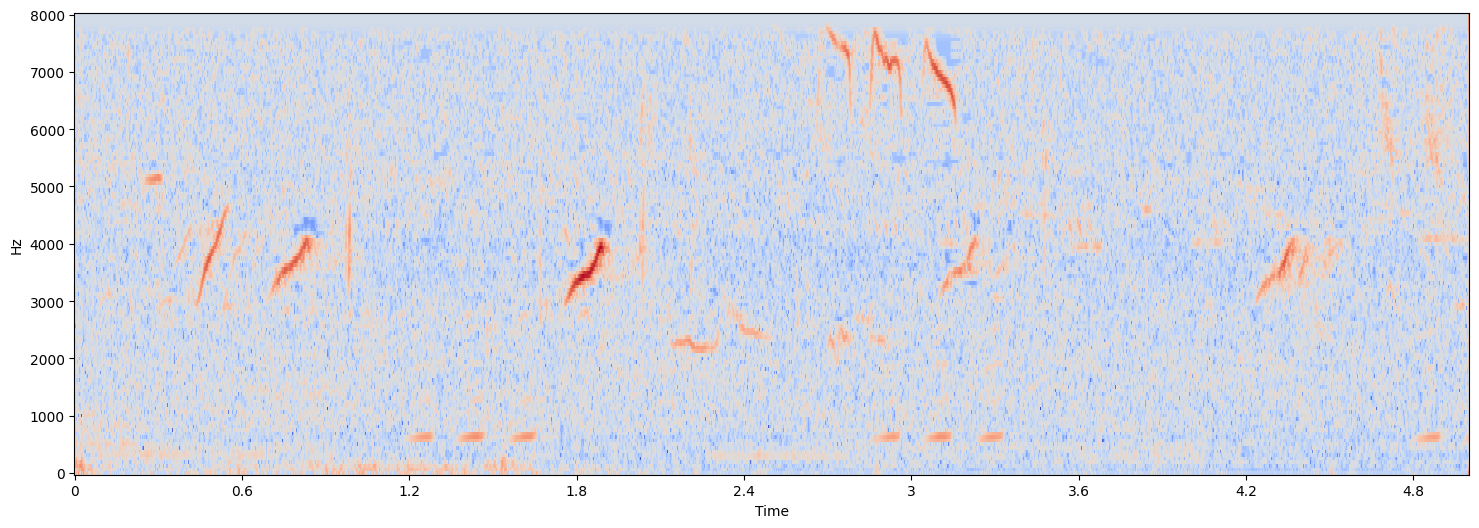

In [ ]:
# S = np.abs(librosa.stft(sample_audio, n_fft=128, hop_length=32))
# S_db = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize=(18,6))
librosa.display.specshow(
    S_db_rs
    , x_axis='time'
    , y_axis='linear'
    , sr=16000
    , hop_length=32
)

In [ ]:
np.min(S_db_rs)

-6.1136584

In [ ]:
np.repeat(np.median(sample_spec, axis=1).reshape(-1,1), 2501, axis=1)

array([[0.3346191 , 0.3346191 , 0.3346191 , ..., 0.3346191 , 0.3346191 ,
        0.3346191 ],
       [0.28522387, 0.28522387, 0.28522387, ..., 0.28522387, 0.28522387,
        0.28522387],
       [0.24101314, 0.24101314, 0.24101314, ..., 0.24101314, 0.24101314,
        0.24101314],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [ ]:
dc_offset_sample, dc_sr = librosa.load(gdi.get_sample_path('train_audio', 'comsan/XC667862.ogg'), sr=None)
Audio(dc_offset_sample, rate=dc_sr)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
librosa.stft(dc_offset_sample, n_fft=256, hop_length=32)[4:,].shape

(125, 78655)

In [ ]:
np.median(dc_offset_sample)

-0.085906

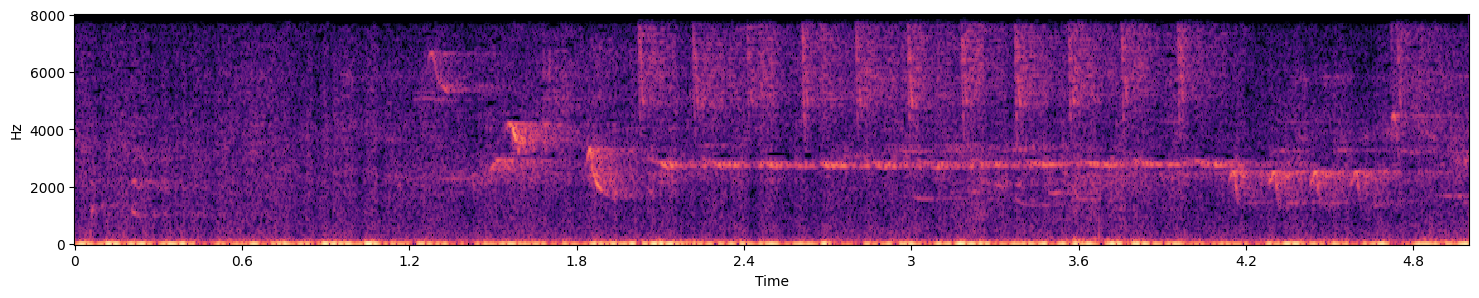

In [ ]:
D = librosa.stft(sample_audio, n_fft=256, hop_length=32)
S, P = librosa.magphase(D, power=1)
S_db = librosa.amplitude_to_db(
    S=S
    #,amin=0.00001
    ,ref=np.max
)
# S_angle = np.angle(S)
plt.figure(figsize=(18,3))
librosa.display.specshow(
    S_db
    , x_axis='time'
    , y_axis='linear'
    , sr=16000
    , hop_length=32
)

In [ ]:
S_db.shape

(129, 2501)

In [ ]:
sample_rms = librosa.feature.rms(
    S=S
)
sample_rms
plt.plot(sample_rms.T)

ParameterError: ignored

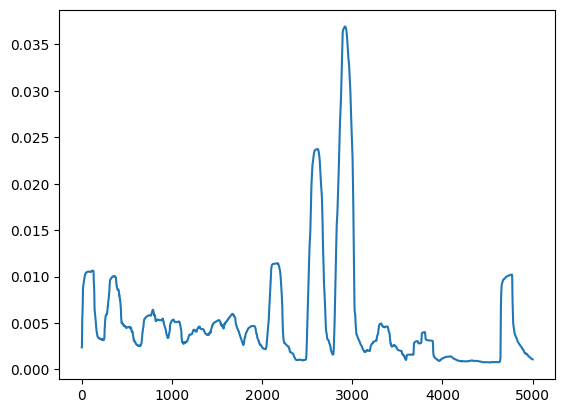

In [ ]:
sample_rms = librosa.feature.rms(
    y=sample_audio
    ,frame_length=2048
    ,hop_length=16
    ,pad_mode='edge'
)
sample_rms
plt.plot(sample_rms.T)

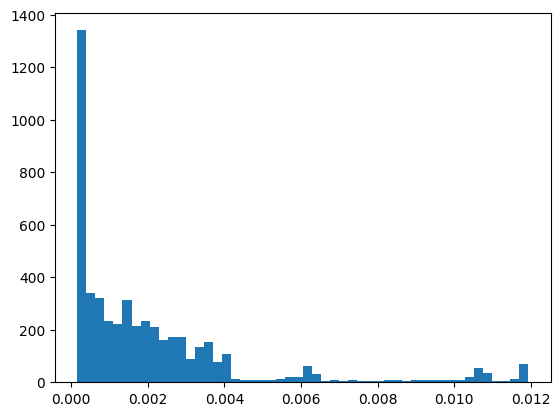

In [ ]:
plt.hist(sample_rms.T, bins=50)
plt.show()

In [ ]:
min_rms_frame = np.argmin(sample_rms)
min_rms_frame

4531

In [ ]:
min_rms_sample_loc = librosa.frames_to_samples(min_rms_frame, hop_length=16)
min_rms_sample_locs = (min_rms_sample_loc - 1024, min_rms_sample_loc + 1024)
min_rms_frames = librosa.samples_to_frames(samples=min_rms_sample_locs, hop_length=16)
min_rms_frames

array([4467, 4595])

In [ ]:
plt.figure(figsize=(6,6))
librosa.display.specshow(
    S_db[:,min_rms_frames[0]:min_rms_frames[1]]
    , x_axis='time'
    , y_axis='linear'
    , sr=16000
    , hop_length=16
)

IndexError: ignored

<Figure size 600x600 with 0 Axes>

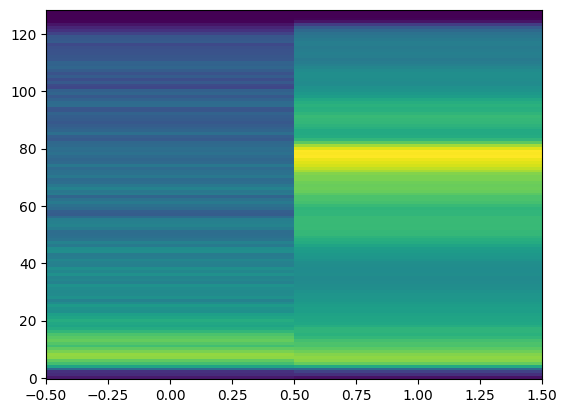

In [ ]:
min_rms_freq_means = np.mean(S_db[:,min_rms_frames[0]:min_rms_frames[1]], axis=1)
all_freq_means = np.mean(S_db, axis=1)
freq_means = np.stack([min_rms_freq_means, all_freq_means])
plt.imshow(freq_means.T, aspect='auto', origin='lower', interpolation='none')

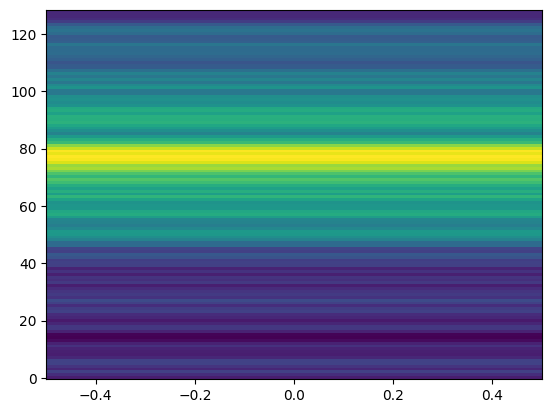

In [ ]:
freq_mean_ratio = all_freq_means-min_rms_freq_means
freq_mean_ratio
plt.imshow(np.expand_dims(freq_mean_ratio, axis=1), aspect='auto', origin='lower', interpolation='none')

In [ ]:
S_db_nr = S_db - np.repeat(min_rms_freq_means.reshape(-1,1), repeats=5001, axis=1)
S_db_nr_min, S_db_nr_max = np.min(S_db_nr), np.max(S_db_nr)
S_db_nr_range = S_db_nr_max - S_db_nr_min
S_db_nr_sc = (S_db_nr - S_db_nr_min)*(80.0/S_db_nr_range)-80
print(S_db_nr_min, S_db_nr_max, S_db_nr_range)

-30.357292 66.105286 96.46258


In [ ]:
print(np.min(S_db), np.min(S_db_nr), np.min(S_db_nr_sc))
print(np.max(S_db), np.max(S_db_nr), np.max(S_db_nr_sc))

-80.0 -30.357292 -80.0
0.0 66.105286 0.0


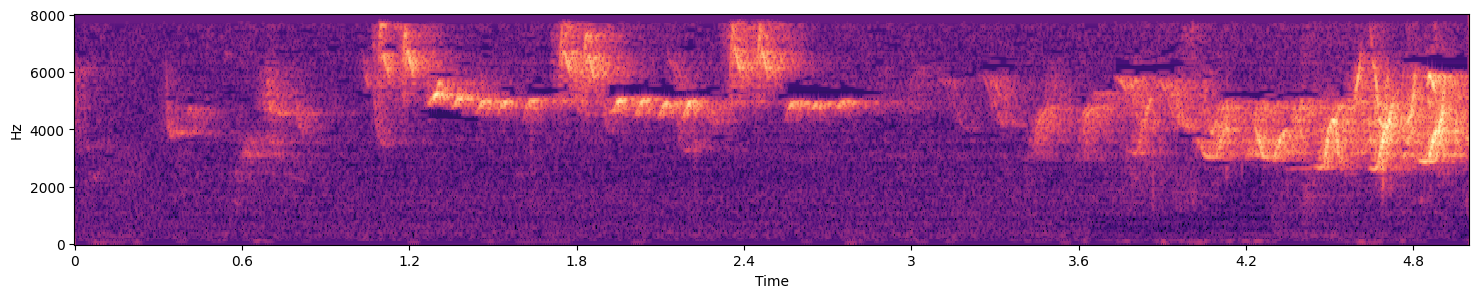

In [ ]:
plt.figure(figsize=(18,3))
librosa.display.specshow(
    S_db_nr_sc
    , x_axis='time'
    , y_axis='linear'
    , sr=16000
    , hop_length=16
)

In [ ]:
S_noise_rescaled = all_freq_means/min_rms_freq_means
freq_mean_ratio
# plt.imshow(np.expand_dims(freq_mean_ratio, axis=1), aspect='auto', origin='lower', interpolation='none')

In [ ]:
D.shape

(129, 5001)

In [ ]:
S_db = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize=(18,6))
librosa.display.specshow(
    S_db
    , x_axis='time'
    , y_axis='linear'
    , sr=16000
    , hop_length=16
)

In [ ]:
plt.imshow(sample_spec[10:30, 1450:1500], origin='lower')
#plt.imshow(sample_spec, origin='lower')

# Model Stored Code

In [232]:
# inputs = tf.keras.Input(shape=(63, 2501))

# permute1 = layers.Permute((2,1))(inputs)

# conv1d_1 = layers.Conv1D(
#     filters=64
#     ,kernel_size=8
#     ,strides=1
#     ,padding='same'
#     ,kernel_constraint=tf.keras.constraints.NonNeg()
#     ,use_bias=False
#     ,activity_regularizer=tf.keras.regularizers.L2(0.1)
# )(permute1)

# conv1d_1 = layers.Conv1D(
#     filters=64
#     ,kernel_size=8
#     ,strides=1
#     ,padding='same'
#     ,kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.0, l2=0.001)
#     ,activation='relu'
# )(permute1)
# conv1d_1_max = layers.MaxPooling1D(
#     pool_size=8
#     ,strides=8
#     ,padding='same'
# )(conv1d_1)

# conv1d_2 = layers.Conv1D(
#     filters=64
#     ,kernel_size=4
#     ,strides=1
#     ,padding='same'
#     ,kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.0, l2=0.001)
#     ,activation='relu'
# )(conv1d_1_max)
# conv1d_2_max = layers.MaxPooling1D(
#     pool_size=4
#     ,strides=4
#     ,padding='same'
# )(conv1d_2)

# conv1d_3 = layers.Conv1D(
#     filters=32
#     ,kernel_size=2
#     ,strides=1
#     ,padding='same'
#     ,kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.0, l2=0.001)
#     ,activation='relu'
# )(conv1d_2_max)
# conv1d_3_max = layers.MaxPooling1D(
#     pool_size=2
#     ,strides=2
#     ,padding='same'
# )(conv1d_3)


# lstm_fwd = layers.LSTM(
#     units=32
#     ,return_sequences=False
#     ,dropout=0.2
#     ,recurrent_dropout=0.2
# )
# lstm_bwd = layers.LSTM(
#     units=32
#     ,return_sequences=False
#     ,go_backwards=True
#     ,dropout=0.2
#     ,recurrent_dropout=0.2
# )
# lstm_bi = layers.Bidirectional(
#     layer=lstm_fwd
#     , backward_layer=lstm_bwd
# )(conv1d_3_max)

# preds = layers.Dense(
#     units=10
#     ,kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.0, l2=0.001)
# )(lstm_bi)

# conv1d_1_m = tf.keras.Model(inputs, conv1d_1)
# conv1d_1_max_m = tf.keras.Model(inputs, conv1d_1_max)
# conv1d_2_m = tf.keras.Model(inputs, conv1d_2)
# conv1d_2_max_m = tf.keras.Model(inputs, conv1d_2_max)
# conv1d_3_m = tf.keras.Model(inputs, conv1d_3)
# conv1d_3_max_m = tf.keras.Model(inputs, conv1d_3_max)
# lstm_bi_m = tf.keras.Model(inputs, lstm_bi)

# model = tf.keras.Model(inputs, preds)
# model.summary()


In [ ]:
# tf.keras.backend.clear_session()

# inputs = tf.keras.Input(shape=(63, 2501))

# permute1 = layers.Permute((2,1))(inputs)


# gru_fwd = layers.GRU(
#     units=16
#     ,return_sequences=True
#     ,dropout=0.1
#     ,recurrent_dropout=0.1
# )
# gru_bwd = layers.GRU(
#     units=16
#     ,return_sequences=True
#     ,go_backwards=True
#     ,dropout=0.1
#     ,recurrent_dropout=0.1
# )
# gru_bi = layers.Bidirectional(
#     layer=gru_fwd
#     , backward_layer=gru_bwd
# )(permute1)

# gru_bi_avgpool = layers.AveragePooling1D(
#     pool_size=5
#     ,strides=5
# )(gru_bi)

# lstm_fwd = layers.LSTM(
#     units=10
#     ,return_sequences=False
#     ,dropout=0.1
#     ,recurrent_dropout=0.1
# )
# lstm_bwd = layers.LSTM(
#     units=10
#     ,return_sequences=False
#     ,go_backwards=True
#     ,dropout=0.1
#     ,recurrent_dropout=0.1
# )
# lstm_bi = layers.Bidirectional(
#     layer=lstm_fwd
#     , backward_layer=lstm_bwd
# )(gru_bi_avgpool)

# preds = layers.Dense(
#     units=10
#     #,kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.0, l2=0.001)
# )(lstm_bi)

# gru_bi_m = tf.keras.Model(inputs, gru_bi)
# gru_bi_avgpool_m = tf.keras.Model(inputs, gru_bi_avgpool)
# lstm_bi_m = tf.keras.Model(inputs, lstm_bi)

# model = tf.keras.Model(inputs, preds)
# model.summary()

# # model.build(input_shape=(None, 129, 5001))
# # model.summary()

In [ ]:
# crop1 = layers.Cropping1D(
#     cropping=(1,0)
# )(inputs)

# conv1d_k1 = layers.Conv1D(
#     filters=64
#     ,kernel_size=1
#     ,strides=1
#     ,groups=64
#     ,padding='valid'
#     ,kernel_initializer='ones'
#     ,bias_initializer='zeros'
# )(permute1)
# conv1d_k1_relu = layers.ReLU(max_value=1.0)(conv1d_k1)

# Reverse = layers.Lambda(
#     lambda x: tf.keras.backend.reverse(x, axes=1)
#     ,output_shape=(None, 2501, 32)
# )
# lstm_bwd_rv = Reverse(lstm_bwd)

#lstm_bi = layers.Concatenate(axis=-1)([lstm_fwd, lstm_bwd])


# lstm_bi_attn_q = layers.Dense(
#     units=8
# )(lstm_bi_attn)
# lstm_bi_attn_k = layers.Dense(
#     units=8
# )(lstm_bi_attn)
# attn_dot = layers.Dot(axes=(2,2))([lstm_bi_attn_q, lstm_bi_attn_k])
# attn_dot_sc = layers.Lambda(lambda x: x / np.sqrt(8.0))(attn_dot)


# dense1 = layers.Dense(
#     units=32
#     ,activation='relu'
# )(lstm_bi)
# dense1_do = layers.Dropout(
#     rate = 0.1
#     , noise_shape=(None,1,32)
# )(dense1, training=True)

# dense2 = layers.Dense(
#     units=65
#     ,bias_initializer=tf.keras.initializers.zeros
# )(dense1)
# dense2_sm = layers.Layer()(dense2)

# mask_dense = layers.Dense(
#     units=1
# )(lstm_bi)
# mask_dense_sm = layers.Softmax(axis=-2)(mask_dense)

# masked_dense = layers.Dot(axes=(1,1))([dense, mask_dense_sm])
# preds = layers.Flatten()(masked_dense)

# dense1 = layers.Dense(
#     units=10
# )(lstm_bi)

# preds1 = layers.GlobalAveragePooling1D()(dense1)



# lstm_fwd = layers.LSTM(
#     units=16
#     ,return_sequences=True
#     ,dropout=0.2
#     ,recurrent_dropout=0.2
# )
# lstm_bwd = layers.LSTM(
#     units=16
#     ,return_sequences=True
#     ,go_backwards=True
#     ,dropout=0.2
#     ,recurrent_dropout=0.2
# )
# lstm_bi = layers.Bidirectional(
#     layer=lstm_fwd
#     , backward_layer=lstm_bwd
# )(permute1)

# lstm_bi_smoothed = layers.AveragePooling1D(
#     pool_size=5
#     ,padding='same'
#     ,strides=2
# )(lstm_bi)
# lstm_fwd_attn = layers.LSTM(
#     units=4
#     ,return_sequences=True
# )
# lstm_bwd_attn = layers.LSTM(
#     units=4
#     ,return_sequences=True
#     ,go_backwards=True
# )
# lstm_bi_attn = layers.Bidirectional(
#     layer=lstm_fwd_attn
#     , backward_layer=lstm_bwd_attn
# )(permute1)
# mask_scores = layers.Dense(
#     units=1
#     ,kernel_regularizer=tf.keras.regularizers.L2(l2=0.1)
#     ,use_bias=False
# )(lstm_bi_attn)
# mask_sm = layers.Softmax(axis=-2)(mask_scores)

# dense = layers.Dense(
#     units=10
# )(lstm_bi)
# dense_wtd_avg = layers.Dot(axes=(1,1))([mask_sm, dense])

# preds = layers.Flatten()(dense_wtd_avg)

# Model-building

In [33]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [34]:
class FFN(layers.Layer):
    def __init__(self, dim, dropout_rate):
        super().__init__()
        self.dim = dim
        self.dropout_rate = dropout_rate
        self.expand = layers.Dense(dim * 2, activation=tf.nn.gelu)
        self.compress = layers.Dense(dim, activation=tf.nn.gelu)
        self.dropout = layers.Dropout(dropout_rate)

    def call(self, patch):
        x = self.expand(patch)
        x = self.dropout(x)
        x = self.compress(x)
        x = self.dropout(x)
        return x

In [ ]:
# class Transformer(layers.Layer):
#   def __init__(self, num_heads, projection_dim)

In [237]:
tf.keras.backend.clear_session()

inputs = tf.keras.Input(shape=(63, 2501))

permute1 = layers.Permute((2,1))(inputs)

# rnn_fwd = layers.SimpleRNN(
#     units=16
#     ,return_sequences=True
# )
# rnn_bwd = layers.SimpleRNN(
#     units=16
#     ,return_sequences=True
#     ,go_backwards=True
# )
# rnn_bi = layers.Bidirectional(
#     layer=rnn_fwd
#     , backward_layer=rnn_bwd
# )(permute1)

add_channel = layers.Reshape(target_shape=(2501, 63, 1))(permute1)

patches0 = tf.image.extract_patches(
    images=add_channel
    , sizes=[1,4,63,1]
    , strides=[1,4,63,1]
    , rates=[1,1,1,1]
    , padding='VALID'
)

patches = layers.Reshape(target_shape=(625, 252))(patches0)
patches_enc = PatchEncoder(625, 32)(patches)

patches_enc_ln = layers.LayerNormalization()(patches_enc)
patches_enc_mha = layers.MultiHeadAttention(
    num_heads=4
    , key_dim=32
    ,dropout=0.1
)(patches_enc_ln, patches_enc_ln)
patches_enc_skip1 = layers.Add()([patches_enc, patches_enc_mha])
patches_enc_ln2 = layers.LayerNormalization()(patches_enc_skip1)
patches_enc_ffn = FFN(32, 0.1)(patches_enc_ln2)
patches_enc_skip2 = layers.Add()([patches_enc_skip1, patches_enc_ffn])

features = layers.GlobalAveragePooling1D()(patches_enc_skip2)
features_ln = layers.LayerNormalization()(features)

preds = layers.Dense(10)(features_ln)


In [239]:
patches_enc_m = tf.keras.Model(inputs, patches_enc)
patches_enc_mha_m = tf.keras.Model(inputs, patches_enc_mha)
patches_enc_ffn_m = tf.keras.Model(inputs, patches_enc_ffn)
transformer_m = tf.keras.Model(inputs, patches_enc_skip2)
features_m = tf.keras.Model(inputs, features)
features_ln_m = tf.keras.Model(inputs, features_ln)

model = tf.keras.Model(inputs, preds)
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 63, 2501)]   0           []                               
                                                                                                  
 permute (Permute)              (None, 2501, 63)     0           ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 2501, 63, 1)  0           ['permute[0][0]']                
                                                                                                  
 tf.image.extract_patches (TFOp  (None, 625, 1, 252)  0          ['reshape[0][0]']                
 Lambda)                                                                                   

In [ ]:
# sample_spec_reshape = specs[batch_item, :, :, 0].T.reshape((1,2501,65))
# sample_spec_reshape.shape

(1, 2501, 65)

In [221]:
conv1d_1_kernels = np.array(conv1d_1_m.get_layer('conv1d').get_weights()[0])
conv1d_1_kernels.shape

(8, 63, 64)

In [ ]:
fig, axs = plt.subplots(1, 16, figsize=(12,6))
for i in range(16):
  axs[i].imshow(conv1d_1_kernels[:,:,i].T, aspect='equal', origin='lower')
  axs[i].axis('off')

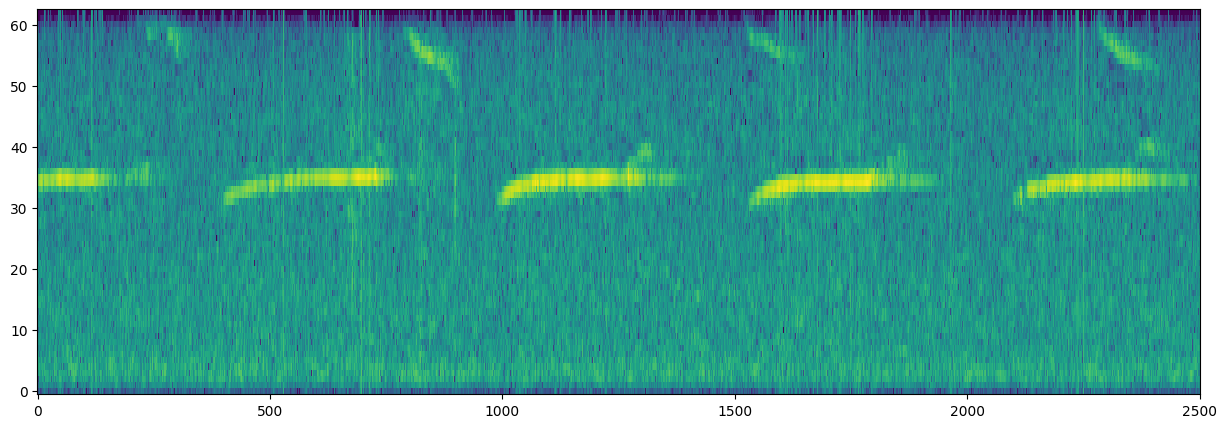

In [362]:
plt.figure(figsize=(15,5))
plt.imshow(sample_spec_db, aspect='auto', origin='lower', interpolation='none')

In [ ]:
# sample_spec_filt_f = librosa.decompose.nn_filter(sample_spec, aggregate=np.median)
# sample_spec_filt_t = librosa.decompose.nn_filter(sample_spec, aggregate=np.median, axis=0)
# filt_thres = -1.0
# sample_spec_filt = (sample_spec_db > filt_thres) * (sample_spec_db - filt_thres)
# plt.figure(figsize=(15,5))
# plt.imshow(sample_spec_filt, aspect='auto', origin='lower', interpolation='none')

In [ ]:
# plt.hist(sample_spec_filt.flatten(), bins=100)
# plt.show()

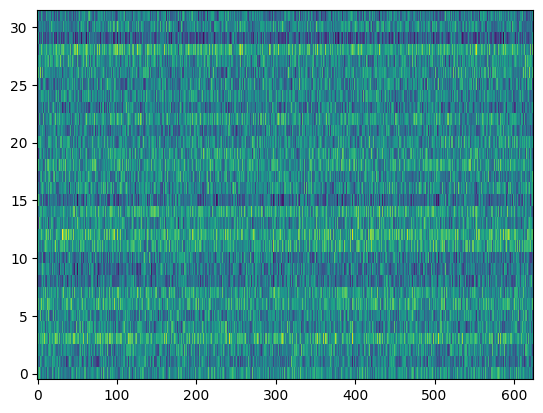

In [346]:
pos_embs = model.get_layer('patch_encoder').get_weights()[2]
plt.imshow(pos_embs.T, aspect='auto', origin='lower', interpolation='none')

In [363]:
resc_input = patches_enc_m(np.expand_dims(sample_spec_db, axis=0))
resc_input_sqz = np.array(tf.squeeze(resc_input))
resc_input_sqz

array([[-2.965371  , -1.1693454 , -1.7549596 , ..., -1.9462668 ,
        -0.47986686, -1.7491634 ],
       [-2.4660652 , -2.6439445 , -1.7815729 , ..., -1.542739  ,
        -0.5470583 , -0.6122823 ],
       [-1.3104877 , -2.727156  , -1.7296965 , ..., -2.348838  ,
         1.5687573 , -0.16031484],
       ...,
       [-2.1240733 , -0.14469488, -2.257959  , ..., -2.2376192 ,
        -0.43303388, -0.2012586 ],
       [-0.9840963 , -2.1982028 , -0.60829365, ..., -0.88754284,
        -0.7417722 , -1.0110059 ],
       [-1.9155622 , -1.0496421 , -1.9619235 , ..., -2.3554583 ,
        -1.9695419 , -2.049398  ]], dtype=float32)

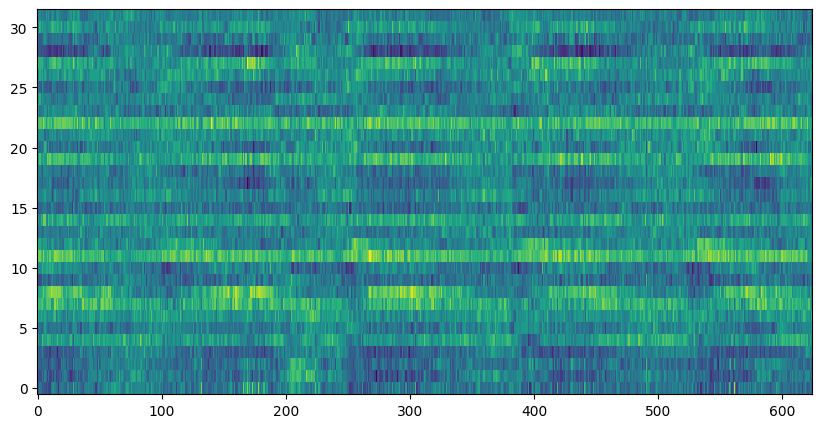

In [374]:
plt.figure(figsize=(10,5))
plt.imshow(resc_input_sqz.T, aspect='auto', origin='lower', interpolation='none')

In [375]:
conv1_out = transformer_m(np.expand_dims(sample_spec_db, axis=0))
conv1_sqz = np.array(tf.squeeze(conv1_out))
conv1_sqz

array([[-3.5861232 , -0.98318833, -2.3677566 , ..., -1.0930474 ,
        -0.5439967 , -1.5886126 ],
       [-2.9354181 , -2.417939  , -2.7162836 , ..., -0.870732  ,
        -0.55120647, -0.55878395],
       [-1.8387536 , -2.6023984 , -2.513143  , ..., -1.3838656 ,
         1.6420428 , -0.04696847],
       ...,
       [-2.8163896 ,  0.14022067, -2.81325   , ..., -1.7592881 ,
        -0.5450393 ,  0.13116859],
       [-1.5482996 , -1.7666357 , -1.05071   , ..., -0.49729198,
        -0.79547644, -0.7522916 ],
       [-1.8893192 , -1.0214007 , -2.5392368 , ..., -2.4523277 ,
        -1.9932749 , -1.9106362 ]], dtype=float32)

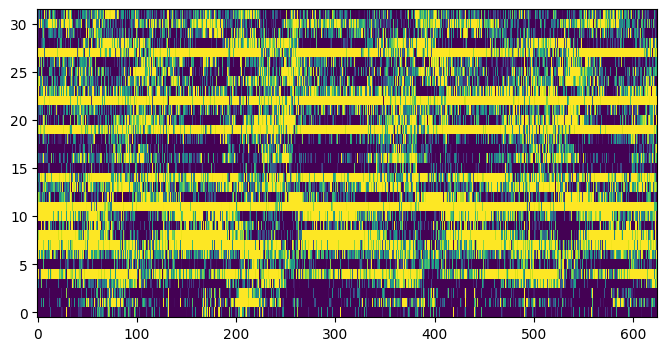

In [376]:
plt.figure(figsize=(8,4))
plt.imshow(conv1_sqz.T, aspect='auto', origin='lower', interpolation='none', vmin=-1.0, vmax=1.0)

In [48]:
conv1_ssm = conv1_sqz @ conv1_sqz.T
conv1_ssm.shape

()

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(conv1_ssm, aspect='auto', origin='lower', interpolation='none')

In [367]:
sample_label

3

In [377]:
preds = model(np.expand_dims(sample_spec, axis=0))
preds_sqz = np.array(tf.squeeze(preds))
preds_sqz

array([-1.7370352 ,  0.7739304 , -1.6238472 ,  3.319372  , -0.01773154,
        2.0938382 ,  0.27787557,  0.5637215 , -0.5265143 ,  1.19564   ],
      dtype=float32)

In [378]:
loss_fn([sample_label], preds)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5148349>

In [379]:
sm = tf.keras.layers.Softmax()
sm(preds)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.00380575, 0.04687473, 0.00426184, 0.59759927, 0.02123853,
        0.1754557 , 0.02854335, 0.03798798, 0.01276918, 0.07146361]],
      dtype=float32)>

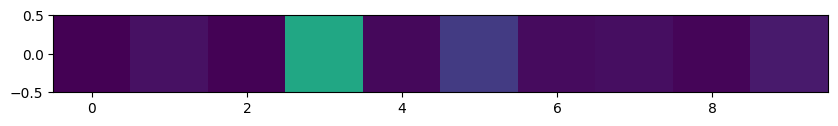

In [380]:
plt.figure(figsize=(10,1))
plt.imshow(np.array(sm(preds)), aspect='auto', origin='lower', interpolation='none', vmin=0, vmax=1)

In [ ]:
filter_num = 3
conv1_filter = conv1_sqz[:,:,filter_num]
plt.figure(figsize=(15,5))
plt.imshow(conv1_filter.T, aspect='auto', origin='lower', interpolation='none')

IndexError: ignored

In [ ]:
check_output = model(specs)
check_output

In [251]:
#optimizer = tf.keras.optimizers.SGD(learning_rate=5e-4)
#optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
losses = []

In [267]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, weight_decay=1e-4)
#optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5)
#optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-3)

In [372]:
epochs=50

for epoch in range(epochs):
  labels, _, _, _, _, _, specs, _ = audio_generator(
      train_idx
      , train_labels
      , train_filepaths
      , train_durations
      , files_per_batch=32
      , batch_size=64
      , prob_smoothing = 0.5
      , clip_length=5.0
      , target_sr=16000
      , n_fft=128
      , hop_length=32
      , min_freq=250
      , augment=True
      )
  with tf.GradientTape() as tape:
    logits = model(specs, training=True)
    loss_value = loss_fn(labels, logits)

  losses.append(float(loss_value))
  grads = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.trainable_weights))

  if epoch % 1 == 0:
    print(f'Batch {epoch} loss: {float(loss_value):.4f}')

/usr/local/lib/python3.10/dist-packages/audiomentations/core/transforms_interface.py:61: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(


Batch 0 loss: 1.3434
Batch 1 loss: 1.2055
Batch 2 loss: 1.5727
Batch 3 loss: 1.5831
Batch 4 loss: 1.3204
Batch 5 loss: 1.3510
Batch 6 loss: 1.4100
Batch 7 loss: 1.6018
Batch 8 loss: 1.5206
Batch 9 loss: 1.3480
Batch 10 loss: 1.0663
Batch 11 loss: 1.5542
Batch 12 loss: 1.4061
Batch 13 loss: 1.9333
Batch 14 loss: 1.2931
Batch 15 loss: 1.2172
Batch 16 loss: 1.3720
Batch 17 loss: 1.9568
Batch 18 loss: 1.1815
Batch 19 loss: 1.1352
Batch 20 loss: 1.5243
Batch 21 loss: 1.2214
Batch 22 loss: 0.8605
Batch 23 loss: 1.4546
Batch 24 loss: 1.2575
Batch 25 loss: 1.2297
Batch 26 loss: 1.1036
Batch 27 loss: 1.2596
Batch 28 loss: 1.6654
Batch 29 loss: 1.0205
Batch 30 loss: 0.8716
Batch 31 loss: 1.3362
Batch 32 loss: 1.4823
Batch 33 loss: 1.6942
Batch 34 loss: 1.2609
Batch 35 loss: 1.3485
Batch 36 loss: 1.4536
Batch 37 loss: 1.3033
Batch 38 loss: 0.9206
Batch 39 loss: 1.4061
Batch 40 loss: 1.2208
Batch 41 loss: 1.6554
Batch 42 loss: 0.8988
Batch 43 loss: 1.1689
Batch 44 loss: 1.4923
Batch 45 loss: 1.118

<Axes: >

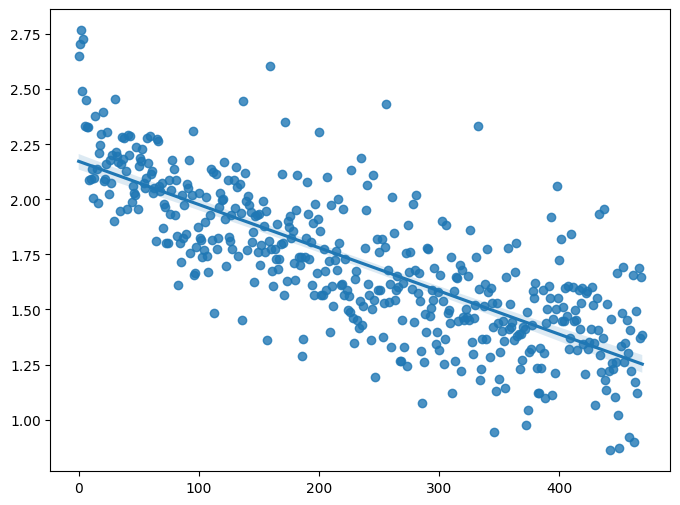

In [373]:
plt.figure(figsize=(8,6))
sns.regplot(x=np.arange(len(losses)), y=losses)

In [ ]:
model.save(gdi.join_to_shared('models/lstm_bidir_v2_loeber'))

In [ ]:
model = tf.keras.models.load_model(gdi.join_to_shared('models/lstm_bidir_loeber'))

In [ ]:
model.compile()

In [ ]:
model.layers